In [1]:
# Local imports
import os
import sys
import glob
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import dask.array as da
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import iris
import cftime

# Specific imports
from tqdm import tqdm
from matplotlib import gridspec
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from scipy.stats import linregress, percentileofscore, gaussian_kde, pearsonr
from scipy.stats import genextreme as gev
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from iris.util import equalise_attributes

# local imports
from gev_functions import pivot_detrend_obs
from process_obs_k_means import (
    pattern_correlation, apply_latitude_weights, normalise_data,
    load_model_data, assign_regimes, calculate_pcr, bootstrapped_clustering, select_most_representative_cluster
)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the df to load from
obs_df_path = "/home/users/benhutch/unseen_multi_year/dfs/block_minima_obs_tas_UK_1960-2017_DJF_2_April.csv"
model_red_df_path = "/home/users/benhutch/unseen_multi_year/dfs/block_minima_model_tas_lead_dt_bc_UK_1960-2017_DJF.csv"
metadata_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/"
saved_obs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/obs/"
var_name = "psl"
region = "NA"  # wider North Atlantic region
season = "DJF"
freq = "day"

# Set up the years
years_list = list(range(1961, 2018))

# import the lats and lons for testing
lats_path = os.path.join(
    metadata_dir,
    f"HadGEM3-GC31-MM_{var_name}_{region}_1961_{season}_{freq}_lats.npy",
)
lons_path = os.path.join(
    metadata_dir,
    f"HadGEM3-GC31-MM_{var_name}_{region}_1961_{season}_{freq}_lons.npy",
)

In [3]:
# Load the data
obs_df = pd.read_csv(obs_df_path)

# Remove the "Unnamed: 0" column
obs_df.drop(columns=["Unnamed: 0"], inplace=True)

# add a new column for the year
obs_df["year"] = obs_df["time"].apply(
    lambda x: (
        x.split("-")[0]
        if x.split("-")[1] == "12"
        else str(int(x.split("-")[0]) - 1)
    )
)

# print the unique years in the obs df
print(obs_df["year"].unique())

# asserrt that the years are correct
assert np.all([str(year) in obs_df["year"].unique() for year in years_list])

['1961' '1962' '1963' '1964' '1965' '1966' '1967' '1968' '1969' '1970'
 '1971' '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980'
 '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990'
 '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' '2012' '2013' '2014' '2015' '2016' '2017']


In [4]:
# ------------------------------
# load the lats and lons
# ------------------------------

# if the file does not exist then raise an error
if not os.path.exists(lats_path):
    raise ValueError(f"File does not exist: {lats_path}")

# Load the lats
lats = np.load(lats_path)

# if the file does not exist then raise an error
if not os.path.exists(lons_path):
    raise ValueError(f"File does not exist: {lons_path}")

# Load the lons
lons = np.load(lons_path)

In [5]:
# ------------------------------
# Load the obs data
# ------------------------------

# Set up an array to store the data
obs_data_arr = np.zeros((len(obs_df), len(lats), len(lons)))

# loop over the years
for i, year in tqdm(
    enumerate(obs_df["effective_dec_year"].unique()), desc="Looping over years"
):
    # get the data for the year
    year_df = obs_df[obs_df["effective_dec_year"] == year]

    # Extract the time from this row
    time_this = year_df["time"].values[0]

    # parse the date string
    year_this, month_this, day_this = map(int, time_this.split("-"))

    # create a cftime datetime object
    time_this = cftime.DatetimeGregorian(
        year_this, month_this, day_this, 11, 0, 0, 0
    )

    # Set up the path to the times from the obs data
    obs_times_path = os.path.join(
        metadata_dir, f"ERA5_{var_name}_{region}_{year}_{season}_{freq}_times.npy"
    )

    # if the file does not exist then raise an error
    if not os.path.exists(obs_times_path):
        raise ValueError(f"File does not exist: {obs_times_path}")

    # Load the times
    obs_times = np.load(obs_times_path)

    # converted to datetime objects
    obs_times = cftime.num2date(
        obs_times, units="hours since 1900-01-01", calendar="gregorian"
    )

    # find the index of time this in obs times
    time_this_index = np.where(obs_times == time_this)[0][0]

    # Form the path to the obs data
    obs_data_path = os.path.join(
        saved_obs_dir, f"ERA5_{var_name}_{region}_{year}_{season}_{freq}.npy"
    )

    # if the file does not exist then raise an error
    if not os.path.exists(obs_data_path):
        raise ValueError(f"File does not exist: {obs_data_path}")

    # Load the data
    obs_data = np.load(obs_data_path)

    # extract the data for the time this
    obs_data_this = obs_data[time_this_index]

    # add the data to the obs data array
    obs_data_arr[i] = obs_data_this


Looping over years: 57it [00:00, 288.21it/s]


In [6]:
obs_data_arr.shape

(57, 90, 96)

In [7]:
# ---------------------------
# Set up the obs data for k means clusteing
# ---------------------------

# Apply latitude weighting
obs_data_arr = apply_latitude_weights(obs_data_arr, lats)

# reshape the data into two dimensions
obs_data_arr = obs_data_arr.reshape(
    (obs_data_arr.shape[0], obs_data_arr.shape[1] * obs_data_arr.shape[2])
)

# set up the scaler
scaler = StandardScaler()

# fit the scaler
scaler.fit(obs_data_arr)

# transform the data
obs_data_arr = scaler.fit_transform(obs_data_arr)


In [8]:
# ---------------------------
# perform the bootstrapped clustering
# ---------------------------

# Set up our optimal K
optimal_K = 5

# Perform bootstrapped clustering
cluster_labels, cluster_centroids = bootstrapped_clustering(
    data=obs_data_arr, K=optimal_K, nboot=100, max_reassign=10
)

# print the cluster labels
print(cluster_labels)

# print the cluster centroids
print(cluster_centroids)

# print the shape of the cluster centroids
print(cluster_centroids.shape)

# print the shape of the cluster labels
print(cluster_labels.shape)

# reshape the cluster centroids
cluster_centroids = cluster_centroids.reshape(
    (cluster_centroids.shape[0], len(lats), len(lons))
)

# Apply the pivot detrend to the obs df
obs_df_dt = pivot_detrend_obs(
    df=obs_df,
    x_axis_name="effective_dec_year",
    y_axis_name="data_c_min"
)

# add a new column to the dataframe for cluster labels
obs_df_dt["cluster_labels"] = cluster_labels

# print the head of the dataframe
print(obs_df_dt.head())

Bootstrapping: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


[1 0 1 2 4 1 1 0 1 0 0 4 4 0 0 4 4 0 4 3 0 3 3 0 4 0 4 0 0 3 1 1 4 3 2 0 1
 0 0 0 2 2 1 1 0 1 0 0 0 1 4 1 2 0 3 1 0]
[[ 0.32997443  0.30869026  0.28607992 ... -0.06011626 -0.0567388
  -0.05205549]
 [-0.02474531 -0.02058867 -0.01631225 ...  0.08829291  0.08656418
   0.08312813]
 [-0.93965934 -0.97352756 -1.00429414 ...  1.15619303  1.15299673
   1.15356716]
 [ 0.51106169  0.5276243   0.54248619 ... -0.68851016 -0.69760568
  -0.70615637]
 [-0.59900149 -0.63361527 -0.66634949 ... -0.00362071 -0.01705938
  -0.03350709]]
(5, 8640)
(57,)
   effective_dec_year  data_c_min        time  year  data_c_min_dt  \
0                1961   -3.468196  1962-01-01  1961      -0.826237   
1                1962   -6.757083  1963-01-12  1962      -4.162302   
2                1963   -2.562683  1963-12-20  1963      -0.015080   
3                1964   -3.339781  1964-12-28  1964      -0.839355   
4                1965   -3.635648  1966-01-19  1965      -1.182400   

   cluster_labels  
0               1  
1

In [93]:
obs_data_arr.shape

(57, 8640)

In [94]:
# reshape the data into 3D
obs_data_arr = obs_data_arr.reshape(
    (obs_data_arr.shape[0], len(lats), len(lons))
)

In [98]:
np.shape(obs_data_arr)

(57, 90, 96)

In [100]:
type(obs_data_arr)

numpy.ndarray

In [101]:
print(obs_data_arr[0])

[[ 1.39338516  1.39355175  1.38878409 ...  0.52009358  0.42279362
   0.31285429]
 [ 1.33765216  1.34675902  1.35110084 ...  0.5500701   0.40776606
   0.26264849]
 [ 1.25928982  1.27966258  1.29563564 ...  0.54713366  0.39304112
   0.21916083]
 ...
 [-1.45608456 -1.45783354 -1.45915156 ... -1.77371842 -1.79037274
  -1.80593717]
 [-1.4888978  -1.49239988 -1.49552863 ... -1.72681943 -1.74189564
  -1.76293271]
 [-1.54974492 -1.55463825 -1.55919084 ... -1.67374414 -1.69249464
  -1.71480034]]


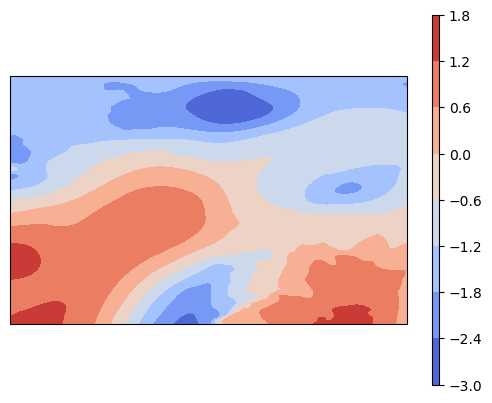

In [102]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# plot the obs data
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the obs
contour = ax.contourf(
    lons,
    lats,
    obs_data_arr[0, :, :],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=50)

plt.show()

In [64]:
# -----------------------------
# Assign the regimes to the data
# -----------------------------

# apply the function to assign regimes
assigned_labels = assign_regimes(
    obs_data=obs_data_arr,
    cluster_centroids=cluster_centroids,
    threshold=1.0
)

# print the assigned labels
print(assigned_labels)

# print the shape of the assigned labels
print(assigned_labels.shape)

# add the assigned labels to the dataframe
obs_df_dt["assigned_labels"] = assigned_labels

# shift the assigned labels by 1
obs_df_dt["assigned_labels"] = obs_df_dt["assigned_labels"] + 1

# print the head of obs_df_dt
print(obs_df_dt.head())

# ptoiny the tail of obs_df_dt
print(obs_df_dt.tail())

[ 3  1  3  3  4  1  2  2  4  4 -1  3 -1  3 -1  2  2 -1  0 -1  3  1  0 -1
  3  1 -1  3  4 -1  0  0 -1  0  4  1  0  0  0  2 -1 -1 -1  1  0  4 -1  1
 -1  2  0  0  0  0 -1  0  1]
(57,)
  effective_dec_year  data_c_min        time  year  data_c_min_dt  \
0               1961   -3.468196  1962-01-01  1961      -0.826237   
1               1962   -6.757083  1963-01-12  1962      -4.162302   
2               1963   -2.562683  1963-12-20  1963      -0.015080   
3               1964   -3.339781  1964-12-28  1964      -0.839355   
4               1965   -3.635648  1966-01-19  1965      -1.182400   

   cluster_labels  assigned_labels  
0               1                4  
1               0                2  
2               1                4  
3               2                4  
4               4                5  
   effective_dec_year  data_c_min        time  year  data_c_min_dt  \
52               2013    2.701735  2014-01-30  2013       2.890447   
53               2014   -0.176357  2015-01

In [51]:
# # add 1 to the cluster labels
# red_dots_df["assigned_labels"] = red_dots_df["assigned_labels"] + 1

In [54]:
# # extract the labels
# labels = red_dots_df["assigned_labels"].values

# # print the labels
# print(labels)

[2 4 2 2 2 5 0 2 0 5 0 0 1 0 0 5 1 0 4 0 1 0 0 4 0 4 0 5 0 5 0 1 2 1 2 2 5
 0 0 4 0 0 4 0 1 0 5 0 4 0 4 3 5 1 5 0 1 1 4 1 3 0 3 1 3 0 2 5 3 5 0 3 5 4]


In [56]:
# # print the years
# years_red = red_dots_df["effective_dec_year"].values

# # print the years
# print(years_red)

['1961-01-01' '1986-01-01' '1971-01-01' '1973-01-01' '1977-01-01'
 '1992-01-01' '1993-01-01' '1961-01-01' '1965-01-01' '1969-01-01'
 '1981-01-01' '1982-01-01' '1992-01-01' '1993-01-01' '1968-01-01'
 '1971-01-01' '1974-01-01' '1975-01-01' '1975-01-01' '1976-01-01'
 '1984-01-01' '1991-01-01' '2002-01-01' '1963-01-01' '1966-01-01'
 '1970-01-01' '1975-01-01' '1976-01-01' '1980-01-01' '1981-01-01'
 '1982-01-01' '1984-01-01' '1987-01-01' '1992-01-01' '1994-01-01'
 '1972-01-01' '1974-01-01' '1974-01-01' '1975-01-01' '1977-01-01'
 '1981-01-01' '1990-01-01' '2004-01-01' '2012-01-01' '1971-01-01'
 '1973-01-01' '1981-01-01' '1987-01-01' '1994-01-01' '1972-01-01'
 '1986-01-01' '1997-01-01' '1970-01-01' '1971-01-01' '1976-01-01'
 '1977-01-01' '1987-01-01' '2006-01-01' '1974-01-01' '1974-01-01'
 '1985-01-01' '1991-01-01' '1997-01-01' '1973-01-01' '1976-01-01'
 '1980-01-01' '1995-01-01' '2002-01-01' '2003-01-01' '2006-01-01'
 '2012-01-01' '1970-01-01' '1970-01-01' '1970-01-01']


In [127]:
obs_df_dt.head()

effective_dec_year  data_c_min        time  year  data_c_min_dt  \
0               1961   -3.468196  1962-01-01  1961      -0.826237   
1               1962   -6.757083  1963-01-12  1962      -4.162302   
2               1963   -2.562683  1963-12-20  1963      -0.015080   
3               1964   -3.339781  1964-12-28  1964      -0.839355   
4               1965   -3.635648  1966-01-19  1965      -1.182400   

   cluster_labels  assigned_labels  
0               1                4  
1               0                2  
2               1                4  
3               2                4  
4               4                5

In [135]:
# format the effective dec years as ints
obs_df_dt["effective_dec_year"] = obs_df_dt["effective_dec_year"].astype(int)

1960
[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
Empty DataFrame
Columns: [effective_dec_year, data_c_min, time, year, data_c_min_dt, cluster_labels, assigned_labels]
Index: []
1961
[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
   effective_dec_year  data_c_min        time  year  data_c_min_dt  \
0                1961   -3.468196  1962-01-01  1961      -0.826237   

   cluster_labels  assigned_labels  
0               1                4  
1962
[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972

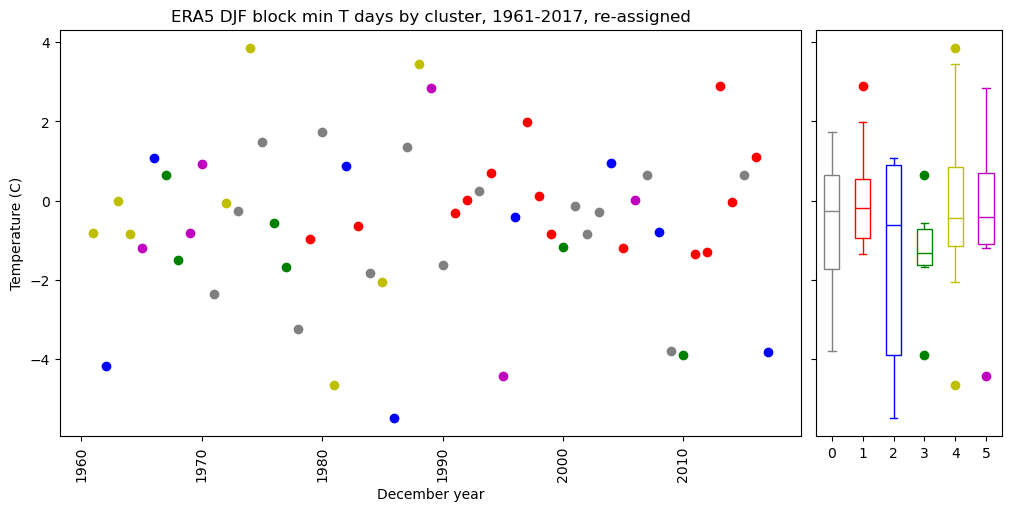

In [138]:
# ----------------------------
# Plot the clusters for different cold days
# ----------------------------

# redo the same figure, but using the updated labels
# Set up a figure to plot the scatter
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, gridspec_kw={"width_ratios": [4, 1]}, layout="compressed")

# set up the colours
colours = ["grey", "r", "b", "g", "y", "m"]

# # loop over the cluster labels
# for i in range(optimal_K + 1):
#     # get the data for this cluster
#     cluster_data = obs_df_dt[obs_df_dt["assigned_labels"] == i]

#     # sort the data by effective_dec_year
#     cluster_data = cluster_data.sort_values(by="effective_dec_year")

#     # if i == 0:
#     if i == 0:
#         # plot the scatter
#         axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_c_min_dt"], label=f"Neutral", color=colours[i])
#     else:
#         # plot the scatter
#         axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_c_min_dt"], label=f"Cluster {i}", color=colours[i])

neutral_flag = False

# loop over the years instead
for year in years_list:
    # format the year as an int
    year = int(year)
    
    # print the year
    print(year)

    # print the effective_dec_year
    print(obs_df_dt["effective_dec_year"].unique())

    # get the data for this year
    year_data = obs_df_dt[obs_df_dt["effective_dec_year"] == year]

    # # sort the data by effective_dec_year
    # year_data = year_data.sort_values(by="effective_dec_year")

    # print the year data
    print(year_data)

    # Initialize a set to keep track of added labels
    added_labels = set()

    # Loop over the cluster labels
    for i in range(optimal_K + 1):
        # If the assigned label does not exist for this i, then continue
        if i not in year_data["assigned_labels"].values:
            continue

        # Get the data for this cluster
        cluster_data = year_data[year_data["assigned_labels"] == i]

        # Sort the data by effective_dec_year
        cluster_data = cluster_data.sort_values(by="effective_dec_year")

        # Determine the label for the scatter plot
        if i == 0:
            label = "Neutral"
        else:
            label = f"Cluster {i}"

        # Plot the scatter with or without the label based on whether it has been added
        if label not in added_labels:
            axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_c_min_dt"], label=label, color=colours[i])
            added_labels.add(label)
        else:
            axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_c_min_dt"], color=colours[i])

# # add the legend
# axs[0].legend()

# set the x label
axs[0].set_xlabel("December year")

# turn the xlabels 90 degrees
axs[0].tick_params(axis="x", rotation=90)

# set the y label
axs[0].set_ylabel("Temperature (C)")

# set the title
axs[0].set_title("ERA5 DJF block min T days by cluster, 1961-2017, re-assigned")

# set up the plots directory
plots_dir = "/home/users/benhutch/unseen_multi_year/plots/"

# Set up the current date time
now = datetime.now()

# Set up a fname for this plot
fname = os.path.join(plots_dir, f"ERA5_{var_name}_{region}_{optimal_K}_clusters_{now}.png")

# create the path to the file
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# create the full path to the files
full_path = os.path.join(plots_dir, fname)

# loop over the cluster labels
for i in range(optimal_K + 1):
    # get the data for this cluster
    cluster_data = obs_df_dt[obs_df_dt["assigned_labels"] == i]

    # plot the boxplot
    axs[1].boxplot(
        cluster_data["data_c_min_dt"],
        positions=[i],
        patch_artist=True,
        boxprops=dict(facecolor="white", color=colours[i]),
        whiskerprops=dict(color=colours[i]),
        capprops=dict(color=colours[i]),
        flierprops=dict(markerfacecolor=colours[i], markeredgecolor=colours[i]),
        medianprops=dict(color=colours[i]),
        vert=True,
        widths=0.5,
    )

# set the xticks
axs[1].set_xticks([i for i in range(optimal_K + 1)])


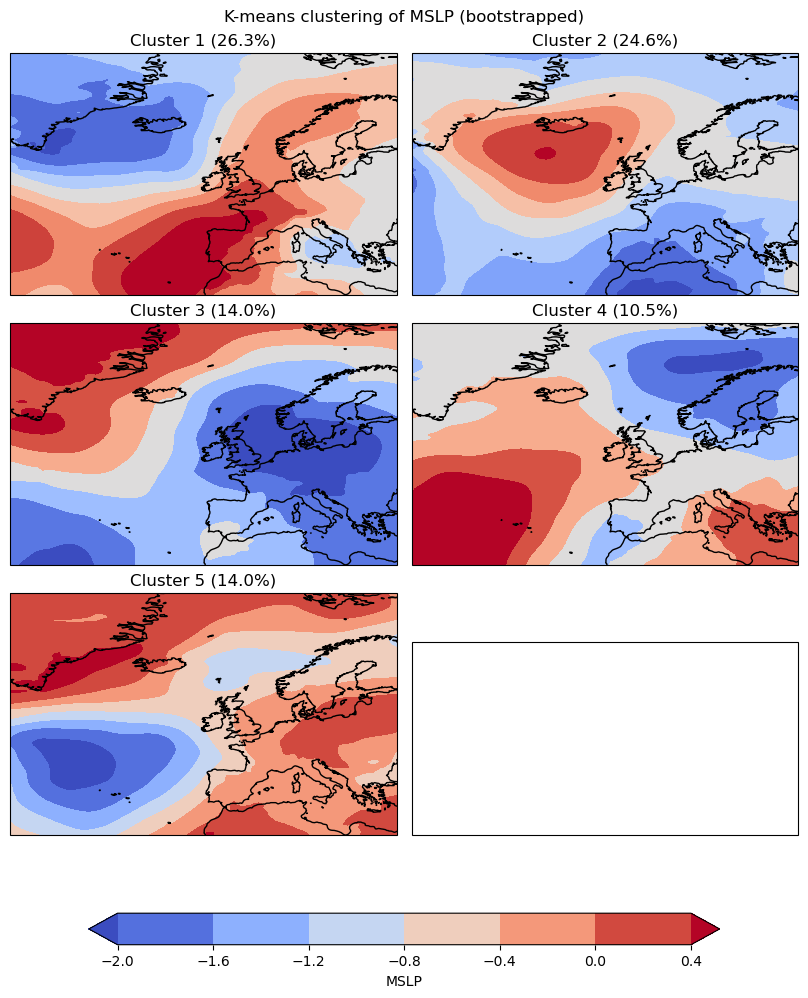

In [11]:
# --------------------------
# Plot the clusters 
# --------------------------

# Set up a figure with 2 cols and 2 rows
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# loop over the cluster centroids
for i, ax in enumerate(axs.flatten()):
    # if i is greater than the number of clusters then break
    if i >= optimal_K:
        break
    
    # set up the plot
    im = ax.contourf(lons, lats, cluster_centroids[i], cmap="coolwarm", extend="both")

    # add coastlines
    ax.coastlines()

    # calculate the % of days in each cluster
    cluster_size = np.sum(obs_df_dt["assigned_labels"] == i) / len(obs_df_dt) * 100

    # add the title
    ax.set_title(f"Cluster {i+1} ({cluster_size:.1f}%)")

# add a colorbar
fig.colorbar(im, ax=axs, orientation="horizontal", label="MSLP", pad=0.1, shrink=0.8)

# Set up a super title
fig.suptitle("K-means clustering of MSLP (bootstrapped)")

# Set up a fname for this figure
fname = os.path.join(plots_dir, f"ERA5_{var_name}_{region}_{optimal_K}_clusters_map_{now}.png")

# create the path to the file
full_path_clusters = os.path.join(plots_dir, fname)

# save the plot
plt.savefig(full_path_clusters, dpi=300)

# show the plot
plt.show()

In [12]:
# ----------------------------
# Load the red dots dataframe
# ----------------------------

# load the red dots array
red_dots_df = pd.read_csv(model_red_df_path)

# print the type of effective dec year in the obs df
print(type(obs_df_dt["effective_dec_year"].values[0]))

# print the type of effective dec year in the red dots df
print(type(red_dots_df["effective_dec_year"].values[0]))

# convert the effective dec year to a string
obs_df_dt["effective_dec_year"] = obs_df_dt["effective_dec_year"].astype(str)

# extract the year from the effective dec year
obs_df_dt["effective_dec_year"] = obs_df_dt["effective_dec_year"].apply(lambda x: x.split("-")[0])

# Set up the array to append the data to
red_dots_arr = np.zeros((len(red_dots_df), len(lats), len(lons)))

# set up the model years
model_years = np.array([str(year) for year in range(1960, 2018)])

# set up the members list
members_list = np.array([10, 1, 2, 3, 4, 5, 6, 7, 8, 9])


<class 'numpy.int64'>
<class 'str'>


In [13]:
# ----------------------------
# Load the model data
# ----------------------------

# set up the save_dir
save_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"
model="HadGEM3-GC31-MM"
temp_res = "day"
arr_shape = 3750
var_name = "psl"
region = "NA"  # wider North Atlantic region
season = "DJF"
years_list = list(range(1961, 2018))

# First load a test array for the first year of years list
test_arr_path = os.path.join(
    save_dir,
    f"{model}_{var_name}_{region}_{years_list[0]}_{season}_{temp_res}.npy",
)

# if the file does not exist then raise an error
if not os.path.exists(test_arr_path):
    raise ValueError(f"File does not exist: {test_arr_path}")

# Load the test array
test_arr = np.load(test_arr_path)

In [35]:
test_arr.shape

(1, 10, 3750, 90, 96)

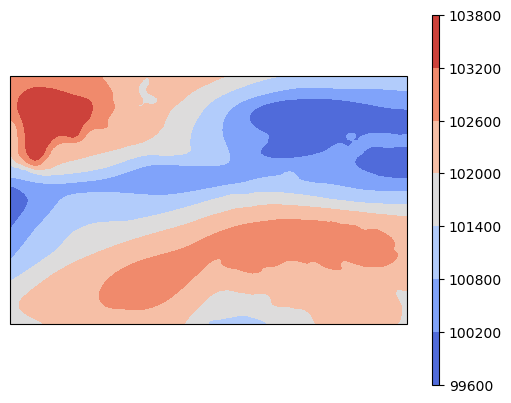

In [103]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# plot the obs data
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the obs
contour = ax.contourf(
    lons,
    lats,
    test_arr[0, 0, 0, :, :],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=50)

plt.show()

In [15]:
red_dots_df.head()

Unnamed: 0  init_year  winter_year  member  data_tas_c_min  lead  \
0           0       1961            1       3       -8.990547    56   
1           1       1986            1       8       -6.935892    85   
2           2       1970            2       1       -8.832334   422   
3           3       1972            2       8       -8.968463   422   
4           4       1976            2       1       -8.539426   445   

  effective_dec_year  data_tas_c_min_dt  data_tas_c_min_dt_bc  
0         1961-01-01          -7.249391             -7.139642  
1         1986-01-01          -5.972038             -5.862289  
2         1971-01-01          -9.238992             -6.216893  
3         1973-01-01          -9.456454             -6.434355  
4         1977-01-01          -9.190080             -6.167980

In [24]:
model_years

array(['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967',
       '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017'], dtype='<U4')

In [25]:
# format model years as a int
model_years = [int(year) for year in model_years]

In [30]:
# make sure that this is an array
model_years = np.array(model_years)

In [109]:
red_dots_df.head()

Unnamed: 0  init_year  winter_year  member  data_tas_c_min  lead  \
0           0       1961            1       3       -8.990547    56   
1           1       1986            1       8       -6.935892    85   
2           2       1970            2       1       -8.832334   422   
3           3       1972            2       8       -8.968463   422   
4           4       1976            2       1       -8.539426   445   

   effective_dec_year  data_tas_c_min_dt  data_tas_c_min_dt_bc  
0                1961          -7.249391             -7.139642  
1                1986          -5.972038             -5.862289  
2                1971          -9.238992             -6.216893  
3                1973          -9.456454             -6.434355  
4                1977          -9.190080             -6.167980

In [142]:
# load in the yellow dots df
fname_yellow = "block_minima_model_tas_dt_UK_1960-2017_DJF_yellow_dots.csv"

# Set up the save directory for the yellow dots
yellow_dots_dir = "/home/users/benhutch/unseen_multi_year/dfs/"

# form the full path to the file
yellow_dots_path = os.path.join(yellow_dots_dir, fname_yellow)

# if the file does not exist then raise an error
if not os.path.exists(yellow_dots_path):
    raise ValueError(f"File does not exist: {yellow_dots_path}")

# Load the yellow dots df
yellow_dots_df = pd.read_csv(yellow_dots_path)

In [144]:
yellow_dots_df.shape

(1498, 9)

In [111]:
# Set up an array to append to
red_dots_arr = np.zeros((len(red_dots_df), test_arr.shape[3], test_arr.shape[4]))

# loop over the rows in df red dots
for i, row in tqdm(
    enumerate(red_dots_df.iterrows()), desc="Looping over red dots"
):
    # get the row
    row = row[1]

    # Extract the init year and winter year
    init_year = int(row["init_year"])
    member = row["member"]
    lead = row["lead"]

    # Include the effective dec year
    effective_dec_year = row["effective_dec_year"]

    # Strip the first 4 characters and format as an int
    effective_dec_year_int = int(effective_dec_year)

    # print the init year and member and lead
    print(init_year, member, lead, effective_dec_year_int)

    # set up the file to extract
    model_data_path = os.path.join(
        save_dir,
        f"{model}_{var_name}_{region}_{init_year}_{season}_{temp_res}.npy",
    )

    # load the data 
    model_data = np.load(model_data_path)

    # print the shape of the data
    print(model_data.shape)

    # print the model year
    print(model_years)

    # # print the init year
    # print(init_year)

    # # print the type of first model years
    # print(type(model_years[0]))

    # # print te type of init year
    # print(type(init_year))

    # # print np.where
    # print(np.where(model_years == init_year))

    # find the index of the init year
    init_year_index = np.where(model_years == init_year)[0][0]

    # find the index of the member
    member_index = np.where(members_list == member)[0][0]

    # find the index of the lead
    lead_index = int(lead) - 1

    # print the indices
    print(init_year_index, member_index, lead_index)

    # extract the data for this member
    model_data_this = model_data[0, member_index, lead_index, :, :]

    # print the shape of model data trhis
    print(model_data_this.shape)

    # append the data to the red dots array
    red_dots_arr[i] = model_data_this

Looping over red dots: 1it [00:00,  5.45it/s]

1961 3.0 56.0 1961
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
1 3 55
(90, 96)
1986 8.0 85.0 1986


Looping over red dots: 3it [00:00,  5.52it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
26 8 84
(90, 96)
1970 1.0 422.0 1971
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
10 1 421
(90, 96)
1972 8.0 422.0 1973


Looping over red dots: 5it [00:00,  5.50it/s]

(1, 10, 3760, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
12 8 421
(90, 96)
1976 1.0 445.0 1977
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
16 1 444
(90, 96)
1991 1.0 459.0 1992


Looping over red dots: 7it [00:01,  5.43it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
31 1 458
(90, 96)
1992 3.0 433.0 1993
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
32 3 432
(90, 96)
1960 2.0 447.0 1961


Looping over red dots: 9it [00:01,  5.09it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
0 2 446
(90, 96)
1963 2.0 792.0 1965
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
3 2 791
(90, 96)
1967 5.0 767.0 1969


Looping over red dots: 11it [00:02,  5.33it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
7 5 766
(90, 96)
1979 7.0 802.0 1981
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
19 7 801
(90, 96)
1980 9.0 785.0 1982


Looping over red dots: 13it [00:02,  5.33it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
20 9 784
(90, 96)
1990 3.0 799.0 1992
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
30 3 798
(90, 96)
1991 2.0 787.0 1993


Looping over red dots: 15it [00:02,  5.35it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
31 2 786
(90, 96)
1965 9.0 1141.0 1968
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
5 9 1140
(90, 96)
1968 6.0 1182.0 1971


Looping over red dots: 17it [00:03,  5.40it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
8 6 1181
(90, 96)
1971 2.0 1152.0 1974
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
11 2 1151
(90, 96)
1972 5.0 1163.0 1975


Looping over red dots: 19it [00:03,  5.41it/s]

(1, 10, 3760, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
12 5 1162
(90, 96)
1972 7.0 1154.0 1975
(1, 10, 3760, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
12 7 1153
(90, 96)
1973 10.0 1156.0 1976


Looping over red dots: 21it [00:03,  5.47it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
13 0 1155
(90, 96)
1981 2.0 1148.0 1984
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
21 2 1147
(90, 96)
1988 4.0 1159.0 1991


Looping over red dots: 23it [00:04,  5.49it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
28 4 1158
(90, 96)
1999 5.0 1150.0 2002
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
39 5 1149
(90, 96)
1960 2.0 1152.0 1963


Looping over red dots: 24it [00:04,  5.03it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
0 2 1151
(90, 96)
1962 4.0 1494.0 1966


Looping over red dots: 26it [00:04,  5.08it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
2 4 1493
(90, 96)
1966 2.0 1527.0 1970
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
6 2 1526
(90, 96)
1971 3.0 1526.0 1975


Looping over red dots: 28it [00:05,  5.24it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
11 3 1525
(90, 96)
1972 2.0 1516.0 1976
(1, 10, 3760, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
12 2 1515
(90, 96)
1976 1.0 1531.0 1980


Looping over red dots: 30it [00:05,  5.40it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
16 1 1530
(90, 96)
1977 9.0 1483.0 1981
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
17 9 1482
(90, 96)
1978 5.0 1520.0 1982


Looping over red dots: 32it [00:05,  5.49it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
18 5 1519
(90, 96)
1980 7.0 1537.0 1984
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
20 7 1536
(90, 96)
1983 4.0 1507.0 1987


Looping over red dots: 34it [00:06,  5.53it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
23 4 1506
(90, 96)
1988 6.0 1490.0 1992
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
28 6 1489
(90, 96)
1990 6.0 1523.0 1994


Looping over red dots: 36it [00:06,  5.46it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
30 6 1522
(90, 96)
1967 4.0 1886.0 1972
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
7 4 1885
(90, 96)
1969 3.0 1888.0 1974


Looping over red dots: 38it [00:07,  5.49it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
9 3 1887
(90, 96)
1969 10.0 1894.0 1974
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
9 0 1893
(90, 96)
1970 10.0 1851.0 1975


Looping over red dots: 40it [00:07,  5.49it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
10 0 1850
(90, 96)
1972 5.0 1868.0 1977
(1, 10, 3760, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
12 5 1867
(90, 96)
1976 9.0 1853.0 1981


Looping over red dots: 42it [00:07,  5.49it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
16 9 1852
(90, 96)
1985 8.0 1876.0 1990
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
25 8 1875
(90, 96)
1999 6.0 1873.0 2004


Looping over red dots: 44it [00:08,  5.52it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
39 6 1872
(90, 96)
2007 9.0 1854.0 2012
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
47 9 1853
(90, 96)
1965 2.0 2253.0 1971


Looping over red dots: 46it [00:08,  5.54it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
5 2 2252
(90, 96)
1967 4.0 2225.0 1973
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
7 4 2224
(90, 96)
1975 8.0 2229.0 1981


Looping over red dots: 48it [00:08,  5.55it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
15 8 2228
(90, 96)
1981 4.0 2260.0 1987
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
21 4 2259
(90, 96)
1988 9.0 2256.0 1994


Looping over red dots: 50it [00:09,  5.55it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
28 9 2255
(90, 96)
1965 8.0 2599.0 1972
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
5 8 2598
(90, 96)
1979 3.0 2594.0 1986


Looping over red dots: 52it [00:09,  5.44it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
19 3 2593
(90, 96)
1990 1.0 2579.0 1997
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
30 1 2578
(90, 96)
1962 10.0 2950.0 1970


Looping over red dots: 54it [00:10,  5.26it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
2 0 2949
(90, 96)
1963 3.0 2936.0 1971
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
3 3 2935
(90, 96)
1968 6.0 2957.0 1976


Looping over red dots: 56it [00:10,  5.39it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
8 6 2956
(90, 96)
1969 2.0 2935.0 1977
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
9 2 2934
(90, 96)
1979 9.0 2931.0 1987


Looping over red dots: 58it [00:10,  5.48it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
19 9 2930
(90, 96)
1998 9.0 2946.0 2006
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
38 9 2945
(90, 96)
1965 8.0 3300.0 1974


Looping over red dots: 60it [00:11,  5.52it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
5 8 3299
(90, 96)
1965 10.0 3316.0 1974
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
5 0 3315
(90, 96)
1976 1.0 3314.0 1985


Looping over red dots: 62it [00:11,  5.54it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
16 1 3313
(90, 96)
1982 2.0 3312.0 1991
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
22 2 3311
(90, 96)
1988 2.0 3310.0 1997


Looping over red dots: 64it [00:11,  5.50it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
28 2 3309
(90, 96)
1963 9.0 3683.0 1973
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
3 9 3682
(90, 96)
1966 2.0 3673.0 1976


Looping over red dots: 66it [00:12,  5.53it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
6 2 3672
(90, 96)
1970 3.0 3697.0 1980
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
10 3 3696
(90, 96)
1985 3.0 3652.0 1995


Looping over red dots: 68it [00:12,  5.57it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
25 3 3651
(90, 96)
1992 1.0 3660.0 2002
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
32 1 3659
(90, 96)
1993 2.0 3683.0 2003


Looping over red dots: 70it [00:12,  5.58it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
33 2 3682
(90, 96)
1996 5.0 3684.0 2006
(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
36 5 3683
(90, 96)
2002 3.0 3674.0 2012


Looping over red dots: 71it [00:13,  5.24it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
42 3 3673
(90, 96)
1960 1.0 3695.0 1970


Looping over red dots: 72it [00:13,  4.88it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
0 1 3694
(90, 96)
1960 7.0 3663.0 1970


Looping over red dots: 73it [00:13,  4.65it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
0 7 3662
(90, 96)
1960 10.0 3656.0 1970


Looping over red dots: 74it [00:13,  5.35it/s]

(1, 10, 3750, 90, 96)
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
0 0 3655
(90, 96)


In [146]:
# strip effective dec year to just the year
yellow_dots_df["effective_dec_year"] = yellow_dots_df["effective_dec_year"].apply(
    lambda x: x.split("-")[0]
)

# format as an int
yellow_dots_df["effective_dec_year"] = yellow_dots_df["effective_dec_year"].astype(
    int
)

In [147]:
%%time
# do the same but for the yellow dots array
yellow_dots_arr = np.zeros((len(yellow_dots_df), test_arr.shape[3], test_arr.shape[4]))

# loop over the rows in df yellow dots
for i, row in tqdm(
    enumerate(yellow_dots_df.iterrows()), desc="Looping over yellow dots"
):
    # get the row
    row = row[1]

    # Extract the init year and winter year
    init_year = int(row["init_year"])
    member = row["member"]
    lead = row["lead"]

    # Include the effective dec year
    effective_dec_year = row["effective_dec_year"]

    # Strip the first 4 characters and format as an int
    effective_dec_year_int = int(effective_dec_year)

    # # print the init year and member and lead
    # print(init_year, member, lead, effective_dec_year_int)

    # set up the file to extract
    model_data_path = os.path.join(
        save_dir,
        f"{model}_{var_name}_{region}_{init_year}_{season}_{temp_res}.npy",
    )

    # load the data 
    model_data = np.load(model_data_path)

    # print the shape of the data
    print(model_data.shape)

    # find the index of the init year
    init_year_index = np.where(model_years == init_year)[0][0]

    # find the index of the member
    member_index = np.where(members_list == member)[0][0]

    # find the index of the lead
    lead_index = int(lead) - 1

    # extract the data for this member
    model_data_this = model_data[0, member_index, lead_index, :, :]

    # append the data to the yellow dots array
    yellow_dots_arr[i] = model_data_this

Looping over yellow dots: 2it [00:00,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 4it [00:00,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 5it [00:00,  5.52it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 6it [00:01,  5.18it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 7it [00:01,  4.99it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 8it [00:01,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 10it [00:01,  4.97it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 12it [00:02,  5.20it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 14it [00:02,  5.31it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 16it [00:03,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 18it [00:03,  5.49it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 20it [00:03,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 22it [00:04,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 24it [00:04,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 26it [00:04,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 28it [00:05,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 30it [00:05,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 32it [00:05,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 33it [00:06,  5.51it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 35it [00:06,  5.24it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 36it [00:06,  5.28it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 38it [00:07,  5.22it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 40it [00:07,  5.38it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 42it [00:07,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 44it [00:08,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 46it [00:08,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 48it [00:08,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 50it [00:09,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 52it [00:09,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 54it [00:10,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 56it [00:10,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 58it [00:10,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 60it [00:11,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 62it [00:11,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 64it [00:11,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 66it [00:12,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 68it [00:12,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 70it [00:12,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 72it [00:13,  5.35it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 74it [00:13,  5.33it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 76it [00:14,  5.20it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 78it [00:14,  5.38it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 80it [00:14,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 82it [00:15,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 83it [00:16,  1.61it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 84it [00:18,  1.05s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 86it [00:19,  1.63it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 87it [00:22,  1.29s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 88it [00:22,  1.03it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 90it [00:22,  1.74it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 92it [00:23,  2.67it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 93it [00:23,  3.16it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 94it [00:25,  1.29it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 96it [00:27,  1.25it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 98it [00:27,  2.07it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 100it [00:29,  1.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 101it [00:29,  1.95it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 102it [10:46, 185.54s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 103it [10:46, 129.95s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 104it [10:47, 91.04s/it] 

(1, 10, 3750, 90, 96)


Looping over yellow dots: 105it [10:47, 63.80s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 107it [10:49, 31.69s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 109it [10:49, 15.63s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 110it [10:49, 10.99s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 112it [10:53,  6.04s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 113it [10:53,  4.29s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 115it [10:56,  2.78s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 116it [10:56,  2.01s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 118it [10:58,  1.43s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 120it [10:58,  1.26it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 122it [11:01,  1.09it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 124it [11:01,  1.87it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 126it [21:14, 129.05s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 128it [21:15, 63.32s/it] 

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 130it [21:17, 31.59s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 131it [21:18, 22.16s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 132it [21:20, 16.21s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 134it [21:22,  8.40s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 135it [21:22,  5.93s/it]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 137it [21:24,  3.38s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 139it [21:25,  1.75s/it]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 141it [21:25,  1.05it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 143it [21:25,  1.79it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 145it [21:26,  2.73it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 147it [21:26,  3.69it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 149it [21:27,  4.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 151it [21:27,  4.95it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 153it [21:27,  5.22it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 155it [21:28,  5.37it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 157it [21:28,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 159it [21:28,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 161it [21:29,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 163it [21:29,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 165it [21:29,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 167it [21:30,  5.44it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 169it [21:30,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 171it [21:31,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 173it [21:31,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 175it [21:31,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 177it [21:32,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 179it [21:32,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 181it [21:32,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 183it [21:33,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 185it [21:33,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 187it [21:33,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 189it [21:34,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 191it [21:34,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 193it [21:34,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 195it [21:35,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 197it [21:35,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 199it [21:36,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 201it [21:36,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 203it [21:36,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 205it [21:37,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 207it [21:37,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 209it [21:37,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 211it [21:38,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 213it [21:38,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 215it [21:38,  5.42it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 217it [21:39,  5.26it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 219it [21:39,  5.32it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 220it [21:39,  5.38it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 221it [21:40,  4.78it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 222it [21:40,  4.43it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 223it [21:40,  4.43it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 225it [21:41,  4.71it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 226it [21:41,  4.94it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 227it [21:41,  4.77it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 229it [21:41,  4.91it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 231it [21:42,  5.22it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 233it [21:42,  5.37it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 234it [21:42,  5.05it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 235it [21:43,  4.99it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 237it [21:43,  5.11it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 238it [21:43,  5.24it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 240it [21:44,  4.75it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 242it [21:44,  4.67it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 244it [21:47,  1.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 246it [21:47,  2.36it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 248it [21:47,  3.27it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 250it [21:48,  4.00it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 252it [21:48,  4.64it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 254it [21:49,  5.04it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 256it [21:49,  5.26it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 258it [21:51,  1.72it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 260it [21:51,  2.70it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 262it [21:52,  3.74it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 264it [21:52,  4.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 266it [21:52,  5.13it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 268it [21:53,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 270it [21:53,  5.77it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 271it [21:53,  5.85it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 272it [21:54,  5.21it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 273it [21:54,  4.84it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 274it [21:54,  4.62it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 275it [21:54,  4.47it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 277it [21:55,  4.67it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 279it [21:55,  5.08it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 281it [21:55,  5.30it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 282it [21:56,  5.36it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 283it [21:56,  5.11it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 285it [21:56,  5.08it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 287it [21:57,  5.25it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 288it [21:57,  5.28it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 290it [21:57,  5.23it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 292it [21:58,  5.38it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 294it [21:58,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 296it [21:58,  5.49it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 298it [21:59,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 300it [21:59,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 302it [21:59,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 304it [22:00,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 306it [22:00,  5.40it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 308it [22:00,  5.39it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 310it [22:01,  5.42it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 312it [22:01,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 314it [22:02,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 316it [22:02,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 318it [22:02,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 320it [22:03,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 322it [22:03,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 324it [22:03,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 326it [22:04,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 328it [22:04,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 330it [22:04,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 332it [22:05,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 334it [22:05,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 336it [22:06,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 338it [22:06,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 340it [22:06,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 342it [22:07,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 344it [22:07,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 346it [22:07,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 348it [22:08,  5.39it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 350it [22:08,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 352it [22:08,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 354it [22:09,  5.41it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 356it [22:09,  5.26it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 358it [22:10,  5.20it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 360it [22:10,  5.16it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 362it [22:10,  5.15it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 364it [22:11,  5.34it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 365it [22:11,  5.41it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 366it [22:11,  4.79it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 367it [22:11,  4.44it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 368it [22:12,  4.43it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 369it [22:12,  4.43it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 370it [22:12,  4.43it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 372it [22:13,  4.71it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 373it [22:13,  4.62it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 375it [22:13,  4.82it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 377it [22:14,  5.17it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 379it [22:14,  5.34it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 380it [22:14,  5.41it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 381it [22:14,  5.06it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 382it [22:15,  4.85it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 383it [22:15,  4.85it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 384it [22:15,  4.85it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 386it [22:15,  5.04it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 387it [22:16,  4.77it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 389it [22:16,  4.59it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 390it [22:16,  4.45it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 392it [22:17,  4.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 394it [22:17,  5.14it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 396it [22:17,  5.33it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 398it [22:18,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 400it [22:18,  5.31it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 402it [22:19,  5.17it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 404it [22:19,  5.25it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 406it [22:19,  5.37it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 408it [22:20,  5.68it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 410it [22:20,  5.81it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 412it [22:20,  5.87it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 414it [22:21,  5.79it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 416it [22:21,  5.75it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 418it [22:21,  5.73it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 420it [22:22,  5.86it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 421it [22:22,  5.90it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 422it [22:22,  5.24it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 423it [22:22,  4.86it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 425it [22:23,  4.85it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 427it [22:23,  5.18it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 428it [22:23,  5.29it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 429it [22:23,  5.06it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 431it [22:24,  5.06it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 433it [22:24,  5.26it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 435it [22:25,  5.42it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 437it [22:25,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 439it [22:25,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 441it [22:26,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 443it [22:26,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 445it [22:26,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 447it [22:27,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 449it [22:27,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 451it [22:27,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 453it [22:28,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 455it [22:28,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 457it [22:29,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 459it [22:29,  5.42it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 461it [22:29,  5.42it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 463it [22:30,  5.42it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 465it [22:30,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 467it [22:30,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 469it [22:31,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 471it [22:31,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 473it [22:31,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 475it [22:32,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 477it [22:32,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 479it [22:33,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 481it [22:33,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 483it [22:33,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 485it [22:34,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 487it [22:34,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 489it [22:34,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 491it [22:35,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 493it [22:35,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 495it [22:35,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 497it [22:36,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 499it [22:36,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 501it [22:37,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 503it [22:37,  5.29it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 505it [22:37,  5.39it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 507it [22:38,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 508it [22:38,  4.83it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 509it [22:38,  4.46it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 510it [22:38,  4.24it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 511it [22:39,  4.09it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 512it [22:39,  4.18it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 514it [22:39,  4.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 516it [22:40,  4.80it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 518it [22:40,  5.17it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 520it [22:40,  5.36it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 522it [22:41,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 523it [22:41,  5.10it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 524it [22:41,  4.89it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 525it [22:41,  4.75it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 526it [22:42,  4.78it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 528it [22:42,  5.01it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 530it [22:42,  5.00it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 532it [22:43,  4.99it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 533it [22:43,  4.70it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 535it [22:44,  4.65it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 537it [22:44,  5.24it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 539it [22:44,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 541it [22:45,  5.26it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 543it [22:45,  5.20it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 545it [22:45,  5.16it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 547it [22:46,  5.25it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 549it [22:46,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 551it [22:46,  5.76it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 553it [22:47,  5.78it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 555it [22:47,  5.79it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 557it [22:48,  5.74it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 559it [22:48,  5.82it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 560it [22:48,  5.88it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 561it [22:48,  5.23it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 562it [22:49,  4.86it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 564it [22:49,  4.86it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 565it [22:49,  4.77it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 566it [22:49,  4.73it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 567it [22:50,  4.70it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 568it [22:50,  4.67it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 570it [22:50,  4.86it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 572it [22:51,  5.19it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 574it [22:51,  5.36it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 576it [22:51,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 578it [22:52,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 580it [22:52,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 582it [22:52,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 584it [22:53,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 586it [22:53,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 588it [22:53,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 590it [22:54,  5.41it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 592it [22:54,  5.42it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 594it [22:55,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 596it [22:55,  5.49it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 598it [22:55,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 600it [22:56,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 602it [22:56,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 604it [22:56,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 606it [22:57,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 608it [22:57,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 610it [22:57,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 612it [22:58,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 614it [22:58,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 616it [22:59,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 618it [22:59,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 620it [22:59,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 622it [23:00,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 624it [23:00,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 626it [23:00,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 627it [23:01,  5.55it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 629it [23:01,  5.37it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 631it [23:01,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 633it [23:02,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 635it [23:02,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 637it [23:02,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 639it [23:03,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 641it [23:03,  5.30it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 643it [23:03,  5.21it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 645it [23:04,  5.39it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 647it [23:04,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 649it [23:05,  5.40it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 651it [23:05,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 652it [23:05,  4.83it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 653it [23:05,  4.47it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 654it [23:06,  4.24it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 655it [23:06,  4.30it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 657it [23:06,  4.64it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 659it [23:07,  5.07it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 661it [23:07,  5.16it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 663it [23:07,  5.32it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 664it [23:08,  5.38it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 665it [23:08,  5.06it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 666it [23:08,  5.00it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 668it [23:08,  5.13it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 670it [23:09,  5.33it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 672it [23:09,  5.14it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 673it [23:09,  4.79it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 675it [23:10,  4.70it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 677it [23:10,  5.05it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 679it [23:11,  5.28it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 681it [23:11,  5.24it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 683it [23:11,  5.37it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 685it [23:12,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 687it [23:12,  5.78it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 689it [23:12,  5.88it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 691it [23:13,  5.90it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 693it [23:13,  5.80it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 694it [23:13,  5.18it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 695it [23:14,  4.83it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 696it [23:14,  4.61it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 697it [23:14,  4.47it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 699it [23:14,  4.67it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 701it [23:15,  5.08it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 703it [23:15,  5.19it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 704it [23:15,  5.28it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 705it [23:16,  5.06it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 707it [23:16,  5.06it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 709it [23:16,  5.23it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 711it [23:17,  5.33it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 713it [23:17,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 715it [23:17,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 717it [23:18,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 719it [23:18,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 721it [23:19,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 723it [23:19,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 725it [23:19,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 727it [23:20,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 729it [23:20,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 731it [23:20,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 733it [23:21,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 735it [23:21,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 737it [23:21,  5.42it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 739it [23:22,  5.41it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 741it [23:22,  5.42it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 743it [23:23,  5.44it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 745it [23:23,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 747it [23:23,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 749it [23:24,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 751it [23:24,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 753it [23:24,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 755it [23:25,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 757it [23:25,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 759it [23:25,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 761it [23:26,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 763it [23:26,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 765it [23:27,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 767it [23:27,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 769it [23:27,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 771it [23:28,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 773it [23:28,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 775it [23:28,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 777it [23:29,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 779it [23:29,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 781it [23:29,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 783it [23:30,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 785it [23:30,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 787it [23:31,  5.32it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 789it [23:31,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 791it [23:31,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 793it [23:32,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 794it [23:32,  5.55it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 795it [23:32,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 796it [23:32,  4.49it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 797it [23:33,  4.26it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 799it [23:33,  4.63it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 801it [23:33,  5.08it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 803it [23:34,  5.02it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 805it [23:34,  5.29it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 807it [23:34,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 808it [23:35,  5.09it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 809it [23:35,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 810it [23:35,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 811it [23:35,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 812it [23:36,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 814it [23:36,  5.06it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 816it [23:36,  5.32it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 818it [23:37,  5.27it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 820it [23:37,  5.12it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 822it [23:37,  5.05it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 824it [23:38,  5.01it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 826it [23:38,  5.35it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 828it [23:39,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 830it [23:39,  5.34it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 832it [23:39,  5.23it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 834it [23:40,  5.29it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 836it [23:40,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 838it [23:40,  5.74it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 839it [23:41,  5.81it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 840it [23:41,  5.20it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 841it [23:41,  4.85it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 843it [23:41,  4.88it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 845it [23:42,  5.21it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 847it [23:42,  5.13it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 849it [23:43,  5.32it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 851it [23:43,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 853it [23:43,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 855it [23:44,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 857it [23:44,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 859it [23:44,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 861it [23:45,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 863it [23:45,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 865it [23:45,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 867it [23:46,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 869it [23:46,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 871it [23:47,  5.31it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 873it [23:47,  5.39it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 875it [23:47,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 877it [23:48,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 879it [23:48,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 881it [23:48,  5.61it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 883it [23:49,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 885it [23:49,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 887it [23:49,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 889it [23:50,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 891it [23:50,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 893it [23:51,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 895it [23:51,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 897it [23:51,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 899it [23:52,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 901it [23:52,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 903it [23:52,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 905it [23:53,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 907it [23:53,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 909it [23:53,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 911it [23:54,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 913it [23:54,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 915it [23:54,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 917it [23:55,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 919it [23:55,  5.62it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 921it [23:56,  5.39it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 923it [23:56,  5.28it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 925it [23:56,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 927it [23:57,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 929it [23:57,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 931it [23:57,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 933it [23:58,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 934it [23:58,  4.88it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 935it [23:58,  4.49it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 936it [23:58,  4.46it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 938it [23:59,  4.74it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 940it [23:59,  5.14it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 942it [24:00,  5.35it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 944it [24:00,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 945it [24:00,  5.50it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 946it [24:00,  5.13it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 947it [24:01,  4.90it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 948it [24:01,  4.89it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 949it [24:01,  4.89it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 950it [24:01,  4.89it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 952it [24:02,  5.08it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 954it [24:02,  5.15it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 956it [24:02,  5.07it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 958it [24:03,  4.82it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 960it [24:03,  4.90it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 962it [24:04,  5.41it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 964it [24:04,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 966it [24:04,  5.34it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 968it [24:05,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 970it [24:05,  5.75it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 971it [24:05,  5.16it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 972it [24:05,  4.83it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 974it [24:06,  4.85it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 975it [24:06,  5.05it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 976it [24:06,  4.93it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 978it [24:07,  5.01it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 980it [24:07,  5.23it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 982it [24:07,  5.40it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 984it [24:08,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 986it [24:08,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 988it [24:08,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 990it [24:09,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 992it [24:09,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 994it [24:10,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 996it [24:10,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 998it [24:10,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1000it [24:11,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 1002it [24:11,  5.45it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 1004it [24:11,  5.46it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1006it [24:12,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1008it [24:12,  5.49it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1010it [24:12,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1012it [24:13,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1014it [24:13,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1016it [24:14,  5.61it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1018it [24:14,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1020it [24:14,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1022it [24:15,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1024it [24:15,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1026it [24:15,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1028it [24:16,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1030it [24:16,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1032it [24:16,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1034it [24:17,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1036it [24:17,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1038it [24:17,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1040it [24:18,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1042it [24:18,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1044it [24:19,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1046it [24:19,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1048it [24:19,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1050it [24:20,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1052it [24:20,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1054it [24:20,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1056it [24:21,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1058it [24:21,  5.61it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1060it [24:21,  5.28it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1062it [24:22,  5.34it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1064it [24:22,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1065it [24:22,  5.50it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1066it [24:23,  4.85it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1067it [24:23,  4.48it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1068it [24:23,  4.47it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1069it [24:23,  4.45it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1070it [24:24,  4.45it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1071it [24:24,  4.45it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1072it [24:24,  4.45it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1073it [24:24,  4.44it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1075it [24:25,  4.74it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1077it [24:25,  5.13it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1078it [24:25,  4.90it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1079it [24:25,  4.76it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1080it [24:26,  4.67it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1081it [24:26,  4.73it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1082it [24:26,  4.73it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1084it [24:26,  4.81it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1086it [24:27,  5.04it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1087it [24:27,  4.74it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1088it [24:27,  4.55it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1090it [24:28,  4.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1092it [24:28,  4.78it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1094it [24:29,  5.23it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1096it [24:29,  5.13it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1098it [24:29,  5.11it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1100it [24:30,  5.23it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1101it [24:30,  5.31it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1102it [24:30,  4.92it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1103it [24:30,  4.68it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1104it [24:31,  4.53it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1105it [24:31,  4.43it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1106it [24:31,  4.35it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1108it [24:31,  4.62it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1109it [24:32,  4.62it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1110it [24:32,  4.63it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1111it [24:32,  4.64it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1113it [24:33,  4.85it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1115it [24:33,  5.13it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1117it [24:33,  5.34it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1119it [24:34,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1121it [24:34,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1123it [24:34,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1125it [24:35,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1127it [24:35,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1129it [24:35,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1131it [24:36,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1133it [24:36,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1135it [24:37,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1137it [24:37,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1139it [24:37,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1141it [24:38,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1143it [24:38,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1145it [24:38,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1147it [24:39,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 1149it [24:39,  5.47it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1151it [24:39,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1153it [24:40,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1155it [24:40,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1157it [24:40,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1159it [24:41,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1161it [24:41,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1163it [24:42,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1165it [24:42,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1167it [24:42,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1169it [24:43,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1171it [24:43,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1173it [24:43,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1175it [24:44,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1177it [24:44,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1179it [24:44,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1181it [24:45,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1183it [24:45,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1185it [24:46,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1187it [24:46,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1189it [24:46,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1191it [24:47,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1193it [24:47,  5.61it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1195it [24:47,  5.40it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1197it [24:48,  5.31it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1199it [24:48,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1201it [24:48,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1202it [24:49,  5.52it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1203it [24:49,  4.86it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1204it [24:49,  4.73it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1205it [24:49,  4.64it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1207it [24:50,  4.84it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1209it [24:50,  4.96it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1211it [24:50,  5.26it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1213it [24:51,  5.41it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1215it [24:51,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1217it [24:52,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1218it [24:52,  5.17it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1219it [24:52,  4.94it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1220it [24:52,  4.80it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1223it [24:53,  5.06it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1225it [24:53,  5.02it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1226it [24:53,  4.61it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1228it [24:54,  4.61it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1230it [24:54,  5.03it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1232it [24:55,  5.35it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1234it [24:55,  5.19it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1236it [24:55,  5.16it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1238it [24:56,  5.02it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1239it [24:56,  5.16it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1240it [24:56,  4.99it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1241it [24:56,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1243it [24:57,  4.96it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1245it [24:57,  5.19it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1247it [24:58,  5.33it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1249it [24:58,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1251it [24:58,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1253it [24:59,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1255it [24:59,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1257it [24:59,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1259it [25:00,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1261it [25:00,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1263it [25:00,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1265it [25:01,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1267it [25:01,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1269it [25:02,  5.45it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1271it [25:02,  5.50it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1273it [25:02,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1275it [25:03,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1277it [25:03,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1279it [25:03,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1281it [25:04,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1283it [25:04,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1285it [25:04,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1287it [25:05,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1289it [25:05,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1291it [25:06,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1293it [25:06,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1295it [25:06,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1297it [25:07,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1299it [25:07,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1301it [25:07,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1303it [25:08,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1305it [25:08,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1307it [25:08,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1309it [25:09,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1311it [25:09,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1313it [25:09,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1315it [25:10,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1317it [25:10,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1319it [25:11,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1321it [25:11,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1323it [25:11,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1325it [25:12,  5.34it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1327it [25:12,  5.36it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1329it [25:12,  5.46it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1331it [25:13,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1333it [25:13,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1334it [25:13,  4.87it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1335it [25:14,  4.49it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1336it [25:14,  4.25it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1337it [25:14,  4.30it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1338it [25:14,  4.34it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1340it [25:15,  4.67it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1341it [25:15,  4.59it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1342it [25:15,  4.54it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1343it [25:15,  4.49it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1345it [25:16,  4.76it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1347it [25:16,  5.13it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1349it [25:17,  5.33it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1351it [25:17,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1352it [25:17,  5.09it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1354it [25:18,  5.07it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1355it [25:18,  5.04it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1356it [25:18,  4.88it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1358it [25:18,  4.93it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1359it [25:19,  4.65it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1360it [25:19,  4.48it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1362it [25:19,  4.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1364it [25:20,  5.06it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1365it [25:20,  5.19it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1367it [25:20,  4.79it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1368it [25:21,  4.59it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1369it [25:21,  4.46it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1370it [25:21,  4.37it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1371it [25:21,  4.31it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1373it [25:22,  4.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1374it [25:22,  4.83it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1375it [25:22,  4.76it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1376it [25:22,  4.72it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1378it [25:23,  4.90it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1380it [25:23,  5.19it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1382it [25:23,  5.36it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1384it [25:24,  5.44it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1386it [25:24,  5.47it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1388it [25:24,  5.49it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1390it [25:25,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1392it [25:25,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1394it [25:26,  5.51it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1396it [25:26,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1398it [25:26,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1400it [25:27,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1402it [25:27,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1404it [25:27,  5.41it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 1406it [25:28,  5.41it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 1408it [25:28,  5.41it/s]

(1, 10, 3760, 90, 96)
(1, 10, 3760, 90, 96)


Looping over yellow dots: 1410it [25:29,  5.45it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1412it [25:29,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1414it [25:29,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1416it [25:30,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1418it [25:30,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1420it [25:30,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1422it [25:31,  5.60it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1424it [25:31,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1426it [25:31,  5.59it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1428it [25:32,  5.58it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1430it [25:32,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1432it [25:32,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1434it [25:33,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1436it [25:33,  5.55it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1438it [25:34,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1440it [25:34,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1442it [25:34,  5.56it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1444it [25:35,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1446it [25:35,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1448it [25:35,  5.57it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1450it [25:36,  5.35it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1452it [25:36,  5.25it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1454it [25:36,  5.40it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1456it [25:37,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1458it [25:37,  5.52it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1459it [25:37,  5.54it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1460it [25:38,  4.84it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1461it [25:38,  4.70it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1463it [25:38,  4.86it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1465it [25:39,  5.20it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1467it [25:39,  5.39it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1469it [25:39,  5.48it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1471it [25:40,  5.53it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1473it [25:40,  5.54it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1474it [25:40,  5.14it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1475it [25:41,  4.91it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1476it [25:41,  4.76it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1478it [25:41,  5.00it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1479it [25:41,  5.16it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1481it [25:42,  5.06it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1483it [25:42,  4.71it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1486it [25:43,  4.89it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1488it [25:43,  5.19it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1490it [25:43,  5.43it/s]

(1, 10, 3750, 90, 96)
(1, 10, 3750, 90, 96)


Looping over yellow dots: 1491it [25:44,  4.98it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1492it [25:44,  4.72it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1493it [25:44,  4.54it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1494it [25:44,  4.42it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1495it [25:45,  4.34it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1496it [25:45,  4.30it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1497it [25:45,  4.26it/s]

(1, 10, 3750, 90, 96)


Looping over yellow dots: 1498it [25:45,  1.03s/it]

(1, 10, 3750, 90, 96)
CPU times: user 2.28 s, sys: 4min 43s, total: 4min 45s
Wall time: 25min 45s


In [148]:
yellow_dots_arr.shape

(1498, 90, 96)

In [149]:
# set up a fname for this yellow dots arr
yellow_dots_fname = f"block_minima_model_tas_dt_UK_1960-2017_DJF_yellow_dots_arr.npy"

# set up the path to save the yellow dots arr
yellow_dots_arr_path = os.path.join(
    "/home/users/benhutch/unseen_multi_year/data", yellow_dots_fname
)

# if the path does not exist then save the array
if not os.path.exists(yellow_dots_arr_path):
    np.save(yellow_dots_arr_path, yellow_dots_arr)
    print(f"Saved yellow dots array to {yellow_dots_arr_path}")


Saved yellow dots array to /home/users/benhutch/unseen_multi_year/data/block_minima_model_tas_dt_UK_1960-2017_DJF_yellow_dots_arr.npy


In [112]:
model_data_this.shape

(90, 96)

In [150]:
# assign regimes to the yellow dots array
yellow_dots_assigned_labels = assign_regimes(
    obs_data=yellow_dots_arr,
    cluster_centroids=cluster_centroids,
    threshold=1.0
)

In [151]:
# add this to the df
yellow_dots_df["assigned_labels"] = yellow_dots_assigned_labels

In [152]:
# add 1 to the assigned labels
yellow_dots_df["assigned_labels"] = yellow_dots_df["assigned_labels"] + 1

In [153]:
# extract just the year from effective dec year
yellow_dots_df["effective_dec_year"] = yellow_dots_df["effective_dec_year"].astype(str)

# extract the year from the effective dec year
yellow_dots_df["effective_dec_year"] = yellow_dots_df["effective_dec_year"].apply(lambda x: x.split("-")[0])

# format this as an int
yellow_dots_df["effective_dec_year"] = yellow_dots_df["effective_dec_year"].astype(int)

# reorder the df into the correct order
yellow_dots_df = yellow_dots_df.sort_values(by=["effective_dec_year", "assigned_labels"])

In [155]:
yellow_dots_df.head()

Unnamed: 0  init_year  winter_year  member  data_tas_c_min  lead  \
0             0       1961            1       2       -3.340369   117   
1             1       1961            1       3       -8.990547    56   
3             3       1961            1       6       -3.424927    48   
2             2       1961            1       4       -3.685203    58   
273         273       1960            2       4       -7.130749   443   

     effective_dec_year  data_tas_c_min_rm_dt  data_tas_c_min_rm_dt_bc  \
0                  1961             -1.698287                -1.824136   
1                  1961             -7.348466                -7.474315   
3                  1961             -1.782846                -1.908695   
2                  1961             -2.043122                -2.168970   
273                1961             -5.488668                -4.711389   

     assigned_labels  
0                  0  
1                  0  
3                  0  
2                  1  
273                1

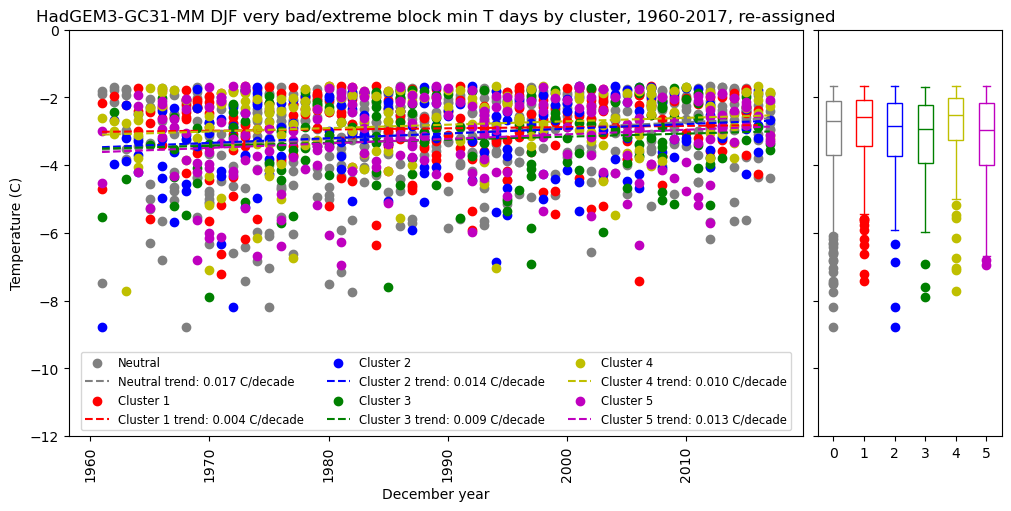

In [159]:
# Set up the figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, gridspec_kw={"width_ratios": [4, 1]}, layout="compressed")

# set up the colours
colours = ["grey", "r", "b", "g", "y", "m"]

# loop over the cluster labels
for i in range(optimal_K + 1):
    # get the data for this cluster
    cluster_data = yellow_dots_df[yellow_dots_df["assigned_labels"] == i]

    # if i == 0:
    if i == 0:
        # plot the scatter
        axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_tas_c_min_rm_dt_bc"], label=f"Neutral", color=colours[i])

        # quantify the trend in neutral regime
        slope, intercept, r_value, p_value, std_err = linregress(
            cluster_data["effective_dec_year"], cluster_data["data_tas_c_min_rm_dt_bc"]
        )

        # plot the trend line as a dashed line
        axs[0].plot(
            cluster_data["effective_dec_year"],
            slope * cluster_data["effective_dec_year"] + intercept,
            color=colours[i],
            linestyle="--",
            label=f"Neutral trend: {slope:.3f} C/decade",
        )

    else:
        # plot the scatter
        axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_tas_c_min_rm_dt_bc"], label=f"Cluster {i}", color=colours[i])

        # quantify the trend in this regime
        slope, intercept, r_value, p_value, std_err = linregress(
            cluster_data["effective_dec_year"], cluster_data["data_tas_c_min_rm_dt_bc"]
        )

        # plot the trend line as a dashed line
        axs[0].plot(
            cluster_data["effective_dec_year"],
            slope * cluster_data["effective_dec_year"] + intercept,
            color=colours[i],
            linestyle="--",
            label=f"Cluster {i} trend: {slope:.3f} C/decade",
        )

# add the legend
axs[0].legend()

# set the x label
axs[0].set_xlabel("December year")

# # Set the xticks for every 5 years
# axs[0].set_xticks([i for i in range(1960, 2018, 5)])

# turn the xlabels by 90 degrees
axs[0].tick_params(axis="x", rotation=90)

# set the y label
axs[0].set_ylabel("Temperature (C)")

# set the title
axs[0].set_title("HadGEM3-GC31-MM DJF very bad/extreme block min T days by cluster, 1960-2017, re-assigned")

# loop over the cluster labels
for i in range(optimal_K + 1):
    # get the data for this cluster
    cluster_data = yellow_dots_df[yellow_dots_df["assigned_labels"] == i]

    # plot the boxplot
    axs[1].boxplot(
        cluster_data["data_tas_c_min_rm_dt_bc"],
        positions=[i],
        patch_artist=True,
        boxprops=dict(facecolor="white", color=colours[i]),
        whiskerprops=dict(color=colours[i]),
        capprops=dict(color=colours[i]),
        flierprops=dict(markerfacecolor=colours[i], markeredgecolor=colours[i]),
        medianprops=dict(color=colours[i]),
        vert=True,
        widths=0.5,
    )

# set the xticks
axs[1].set_xticks([i for i in range(optimal_K + 1)])

# set the ylims
axs[0].set_ylim([-12, 0])

# set up the legend with three columns
axs[0].legend(
    loc="lower center",
    ncol=3,
    fontsize="small",
)

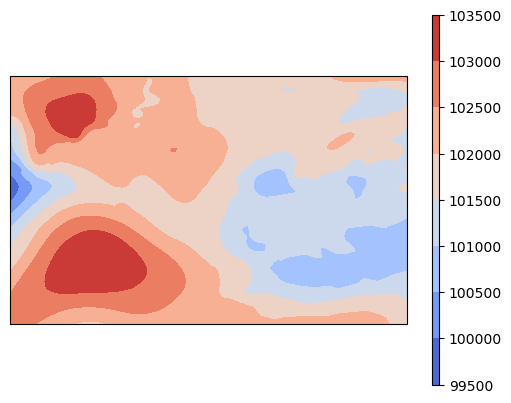

In [113]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# plot the obs data
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the obs
contour = ax.contourf(
    lons,
    lats,
    red_dots_arr[11],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=50)

plt.show()

In [120]:
# ----------------------------
# Calculate the NAO for each of these
# ----------------------------

# Define the dimensions for the gridbox for the azores
azores_grid_corrected = {"lon1": -28, "lon2": -20, "lat1": 36, "lat2": 40}

# Define the dimensions for the gridbox for the azores
iceland_grid_corrected = {"lon1": -25, "lon2": -16, "lat1": 63, "lat2": 70}

# Set up an empty list for the years
years = []

# Set up an empty list for the nao
nao = []

# find the lat and lon indices for the azores
lon1_azores_index = np.abs(lons - azores_grid_corrected["lon1"]).argmin()
lon2_azores_index = np.abs(lons - azores_grid_corrected["lon2"]).argmin()
lat1_azores_index = np.abs(lats - azores_grid_corrected["lat1"]).argmin()
lat2_azores_index = np.abs(lats - azores_grid_corrected["lat2"]).argmin()

# find the lat and lon indices for iceland
lon1_iceland_index = np.abs(lons - iceland_grid_corrected["lon1"]).argmin()
lon2_iceland_index = np.abs(lons - iceland_grid_corrected["lon2"]).argmin()
lat1_iceland_index = np.abs(lats - iceland_grid_corrected["lat1"]).argmin()
lat2_iceland_index = np.abs(lats - iceland_grid_corrected["lat2"]).argmin()


# First calculate the climatology for these regions
# Subset the data for the azores
azores_data = red_dots_arr[:, lat1_azores_index:lat2_azores_index, lon1_azores_index:lon2_azores_index]

# Subset the data for iceland
iceland_data = red_dots_arr[:, lat1_iceland_index:lat2_iceland_index, lon1_iceland_index:lon2_iceland_index]

# Calculate the mean for the azores
azores_mean = np.mean(azores_data, axis=(0, 1, 2))

# Calculate the mean for iceland
iceland_mean = np.mean(iceland_data, axis=(0, 1, 2))

# Calculate the nao by looping over the indices in red dots arr
for i in tqdm(range(red_dots_arr.shape[0]), desc="Calculating NAO"):
    # get the data for this cluster
    azores_data_this = azores_data[i]
    iceland_data_this = iceland_data[i]

    # calculate the azores anoms this
    azores_anoms_this = azores_data_this.mean(axis=(0, 1)) - azores_mean

    # calculate the iceland anoms this
    iceland_anoms_this = iceland_data_this.mean(axis=(0, 1)) - iceland_mean

    # calculate the nao
    nao_this = azores_anoms_this - iceland_anoms_this

    # append the nao to the list
    nao.append(nao_this)

    # append the year to the list
    years.append(red_dots_df["effective_dec_year"].values[i])

Calculating NAO: 100%|██████████| 74/74 [00:00<00:00, 103494.00it/s]


In [124]:
# turn the nao into a numpy array
nao = np.array(nao)

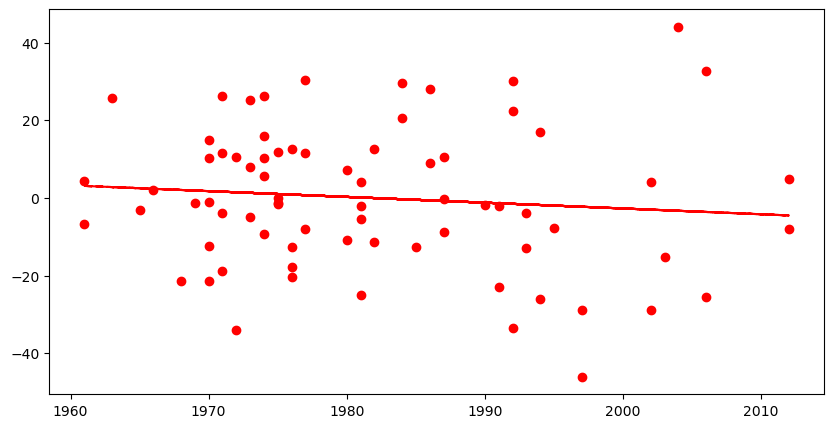

In [126]:
# Plot the years on the x-axis
# and the nao on the y-axis
plt.figure(figsize=(10, 5))

# plot the nao
plt.scatter(years, nao / 100, marker="o", color="red")

# fit a straight line to the data
slope, intercept, r_value, p_value, std_err = linregress(years, nao / 100)

# plot the line
plt.plot(years, slope * np.array(years) + intercept, color="red", linestyle="--")

Looping over years: 16it [00:00, 155.84it/s]

Year 1960 not in red dots df
Plot index: 0, Year: 1961
Plot index: 1, Year: 1961
Year 1962 not in red dots df
Plot index: 2, Year: 1963
Year 1964 not in red dots df
Plot index: 3, Year: 1965
Plot index: 4, Year: 1966
Year 1967 not in red dots df
Plot index: 5, Year: 1968
Plot index: 6, Year: 1969
Plot index: 7, Year: 1970
Plot index: 8, Year: 1970
Plot index: 9, Year: 1970
Plot index: 10, Year: 1970
Plot index: 11, Year: 1970
Plot index: 12, Year: 1971
Plot index: 13, Year: 1971
Plot index: 14, Year: 1971
Plot index: 15, Year: 1971
Plot index: 16, Year: 1972
Plot index: 17, Year: 1972
Plot index: 18, Year: 1973
Plot index: 19, Year: 1973
Plot index: 20, Year: 1973
Plot index: 21, Year: 1974
Plot index: 22, Year: 1974
Plot index: 23, Year: 1974
Plot index: 24, Year: 1974
Plot index: 25, Year: 1974
Plot index: 26, Year: 1975
Plot index: 27, Year: 1975
Plot index: 28, Year: 1975
Plot index: 29, Year: 1975
Plot index: 30, Year: 1976
Plot index: 31, Year: 1976
Plot index: 32, Year: 1976
Plo

Looping over years: 58it [00:00, 227.46it/s]


Plot index: 59, Year: 1993
Plot index: 60, Year: 1993
Plot index: 61, Year: 1994
Plot index: 62, Year: 1994
Plot index: 63, Year: 1995
Year 1996 not in red dots df
Plot index: 64, Year: 1997
Plot index: 65, Year: 1997
Year 1998 not in red dots df
Year 1999 not in red dots df
Year 2000 not in red dots df
Year 2001 not in red dots df
Plot index: 66, Year: 2002
Plot index: 67, Year: 2002
Plot index: 68, Year: 2003
Plot index: 69, Year: 2004
Year 2005 not in red dots df
Plot index: 70, Year: 2006
Plot index: 71, Year: 2006
Year 2007 not in red dots df
Year 2008 not in red dots df
Year 2009 not in red dots df
Year 2010 not in red dots df
Year 2011 not in red dots df
Plot index: 72, Year: 2012
Plot index: 73, Year: 2012
Year 2013 not in red dots df
Year 2014 not in red dots df
Year 2015 not in red dots df
Year 2016 not in red dots df
Year 2017 not in red dots df


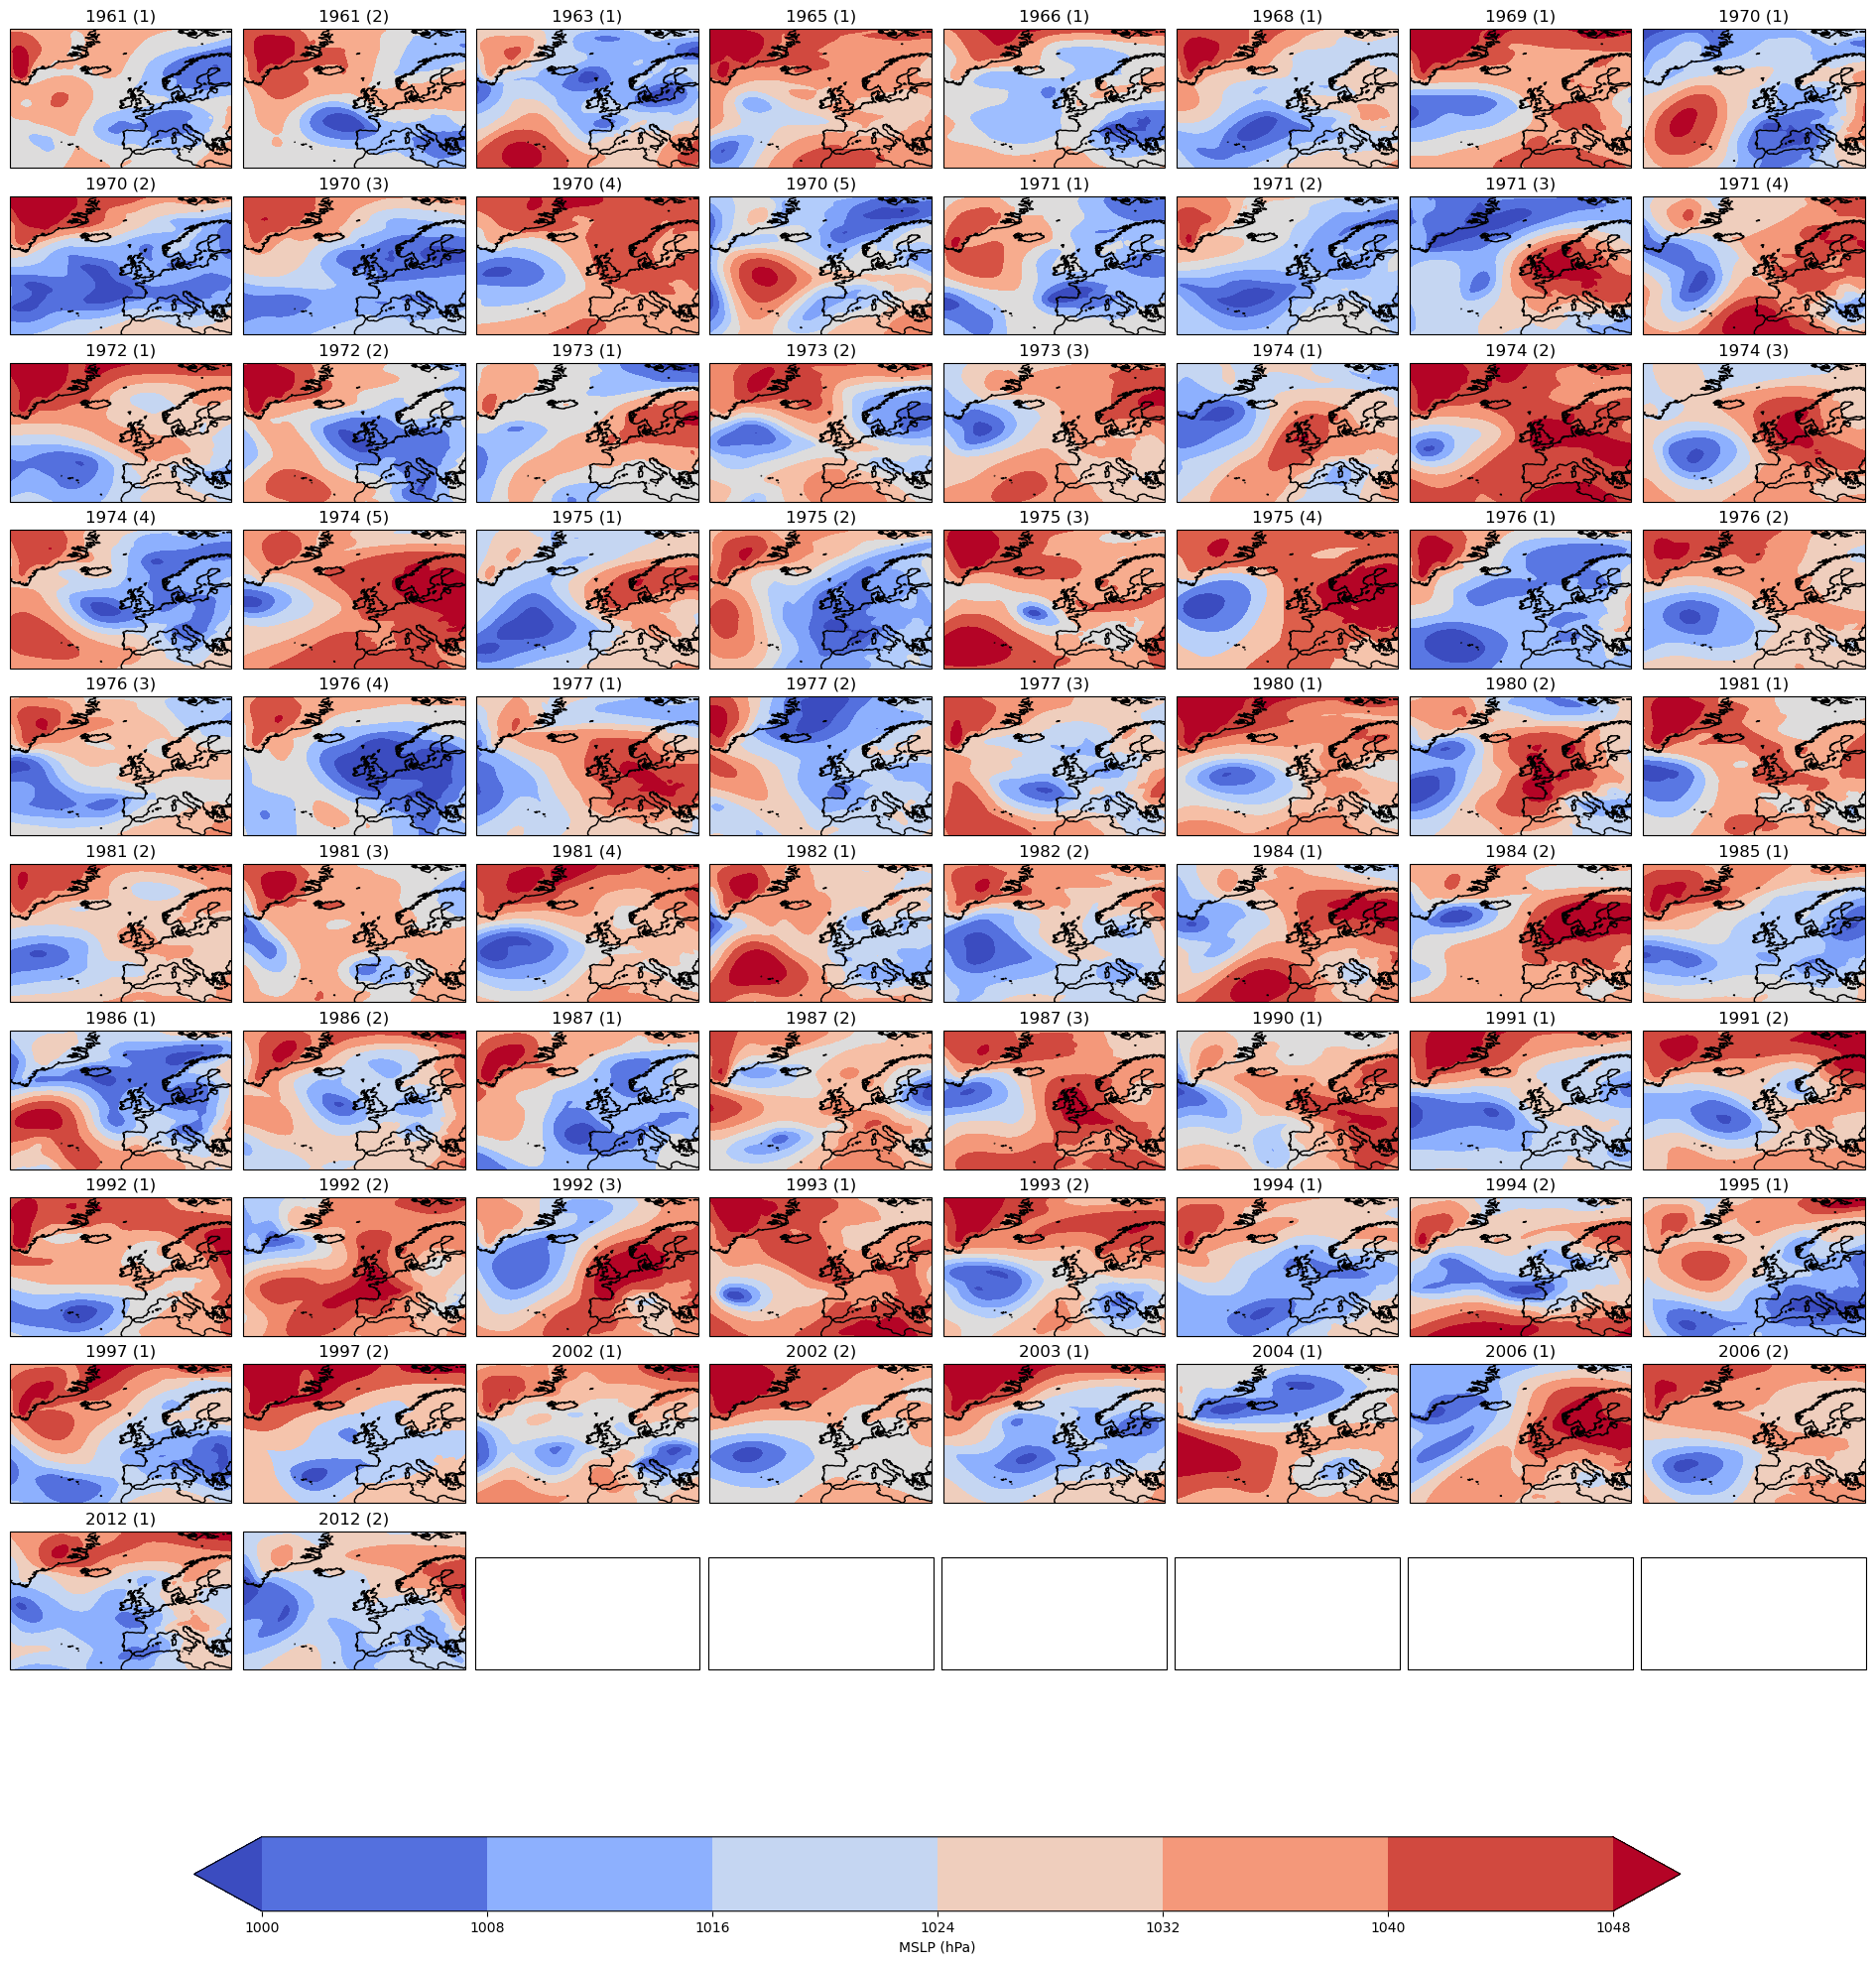

In [119]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from tqdm import tqdm

# Plot all of the data with 10 rows and 8 columns
fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(20, 20), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# Set up the years to loop over
years_list = np.arange(1960, 2018, 1)

# Flatten the axes
axs_flat = axs.flatten()

plot_index = 0

# Loop over the years list
for i, year in tqdm(enumerate(years_list), desc="Looping over years"):
    # Check whether the year is in the red dots df
    if year not in red_dots_df["effective_dec_year"].unique():
        print(f"Year {year} not in red dots df")
        continue

    # Find the indexes of the rows which have data for this year
    year_indexes = np.where(red_dots_df["effective_dec_year"] == year)[0]

    # Loop over the indexes
    for j, index in enumerate(year_indexes):
        print(f"Plot index: {plot_index}, Year: {year}")

        # Extract this index from the red dots arr
        red_dots_arr_this = red_dots_arr[index, :, :]

        # Calculate the row and column index based on the plot index
        row_index = plot_index // 8
        col_index = plot_index % 8

        # Plot the data at this index
        im = axs[row_index, col_index].contourf(lons, lats, red_dots_arr_this / 100, cmap="coolwarm", extend="both")

        # Add coastlines
        axs[row_index, col_index].coastlines()

        # Add the title
        axs[row_index, col_index].set_title(f"{year} ({j+1})")

        # Increment the plot index
        plot_index += 1

# Add the colorbar
cbar = fig.colorbar(im, ax=axs_flat, orientation="horizontal", label="MSLP (hPa)", pad=0.1, shrink=0.8)

plt.show()

In [38]:
red_dots_arr.shape

(74, 90, 96)

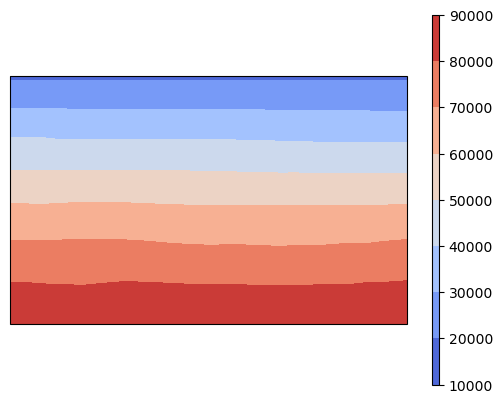

In [104]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# plot the obs data
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the obs
contour = ax.contourf(
    lons,
    lats,
    red_dots_arr[0, :, :],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=50)

plt.show()

In [41]:
# set up a fname for this array
fname = os.path.join(
    "/home/users/benhutch/unseen_multi_year/data",
    f"{model}_{var_name}_{region}_{season}_{temp_res}_red_dots_{now}.npy",
)

print(fname)

# # if the path does not exist then save the file
# if not os.path.exists(os.path.dirname(fname)):
#     np.save(fname, red_dots_arr)

# if the flile does not exist then raise an error
if not os.path.exists(fname):
    # save the file
    np.save(fname, red_dots_arr)



/home/users/benhutch/unseen_multi_year/data/HadGEM3-GC31-MM_psl_NA_DJF_day_red_dots_2025-04-03 11:49:45.659938.npy


In [42]:
# assign the red dots
# Apply latitude weighting
red_dots_arr = apply_latitude_weights(red_dots_arr, lats)

# use the function to assign labels
red_dots_arr_labels = assign_regimes(
    obs_data=red_dots_arr,
    cluster_centroids=cluster_centroids,
    threshold=1.0
)

In [43]:
# add these to the df
red_dots_df["assigned_labels"] = red_dots_arr_labels

In [45]:
red_dots_df.head()

Unnamed: 0  init_year  winter_year  member  data_tas_c_min  lead  \
0           0       1961            1       3       -8.990547    56   
1           1       1986            1       8       -6.935892    85   
2           2       1970            2       1       -8.832334   422   
3           3       1972            2       8       -8.968463   422   
4           4       1976            2       1       -8.539426   445   

  effective_dec_year  data_tas_c_min_dt  data_tas_c_min_dt_bc  assigned_labels  
0         1961-01-01          -7.249391             -7.139642                1  
1         1986-01-01          -5.972038             -5.862289                3  
2         1971-01-01          -9.238992             -6.216893                1  
3         1973-01-01          -9.456454             -6.434355                1  
4         1977-01-01          -9.190080             -6.167980                1

In [50]:
red_dots_df["assigned_labels"].unique()

array([ 1,  3,  4, -1,  0,  2])

In [ ]:
# add 1 to the assigned labels
red_dots_df["assigned_labels"] = red_dots_df["assigned_labels"] + 1

In [57]:
red_dots_df["assigned_labels"].unique()

array([2, 4, 5, 0, 1, 3])

In [62]:
# extract just the year from effective dec year
red_dots_df["effective_dec_year"] = red_dots_df["effective_dec_year"].astype(str)

# extract the year from the effective dec year
red_dots_df["effective_dec_year"] = red_dots_df["effective_dec_year"].apply(lambda x: x.split("-")[0])

# format this as an int
red_dots_df["effective_dec_year"] = red_dots_df["effective_dec_year"].astype(int)

# reorder the df into the correct order
red_dots_df = red_dots_df.sort_values(by=["effective_dec_year", "assigned_labels"])

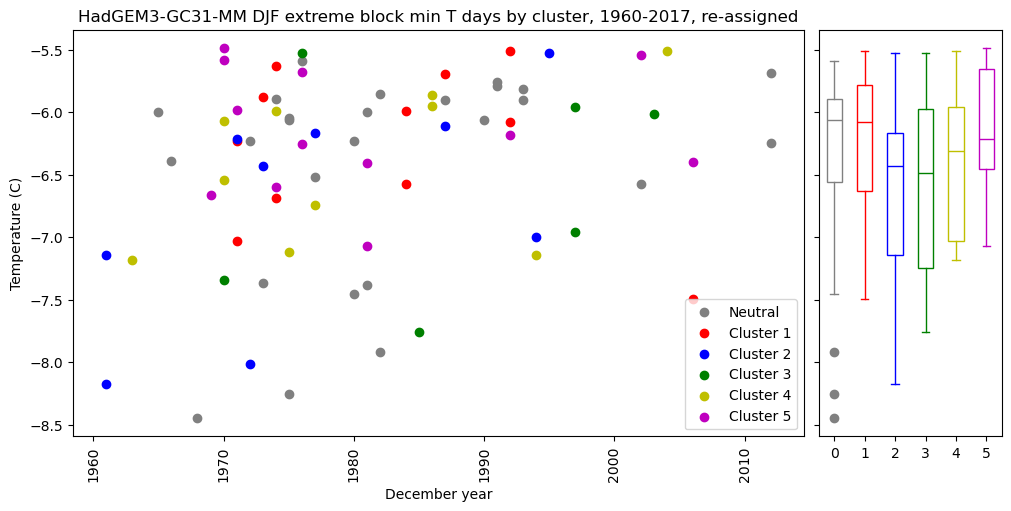

In [63]:
# Set up the figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, gridspec_kw={"width_ratios": [4, 1]}, layout="compressed")

# set up the colours
colours = ["grey", "r", "b", "g", "y", "m"]

# loop over the cluster labels
for i in range(optimal_K + 1):
    # get the data for this cluster
    cluster_data = red_dots_df[red_dots_df["assigned_labels"] == i]

    # if i == 0:
    if i == 0:
        # plot the scatter
        axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_tas_c_min_dt_bc"], label=f"Neutral", color=colours[i])
    else:
        # plot the scatter
        axs[0].scatter(cluster_data["effective_dec_year"], cluster_data["data_tas_c_min_dt_bc"], label=f"Cluster {i}", color=colours[i])

# add the legend
axs[0].legend()

# set the x label
axs[0].set_xlabel("December year")

# # Set the xticks for every 5 years
# axs[0].set_xticks([i for i in range(1960, 2018, 5)])

# turn the xlabels by 90 degrees
axs[0].tick_params(axis="x", rotation=90)

# set the y label
axs[0].set_ylabel("Temperature (C)")

# set the title
axs[0].set_title("HadGEM3-GC31-MM DJF extreme block min T days by cluster, 1960-2017, re-assigned")

# loop over the cluster labels
for i in range(optimal_K + 1):
    # get the data for this cluster
    cluster_data = red_dots_df[red_dots_df["assigned_labels"] == i]

    # plot the boxplot
    axs[1].boxplot(
        cluster_data["data_tas_c_min_dt_bc"],
        positions=[i],
        patch_artist=True,
        boxprops=dict(facecolor="white", color=colours[i]),
        whiskerprops=dict(color=colours[i]),
        capprops=dict(color=colours[i]),
        flierprops=dict(markerfacecolor=colours[i], markeredgecolor=colours[i]),
        medianprops=dict(color=colours[i]),
        vert=True,
        widths=0.5,
    )

# set the xticks
axs[1].set_xticks([i for i in range(optimal_K + 1)])

In [66]:
red_dots_arr.shape

(74, 90, 96)

In [69]:
# import the red dots df again
red_dots_df = pd.read_csv(model_red_df_path)

# print the head of the red dots df
red_dots_df.head()

Unnamed: 0  init_year  winter_year  member  data_tas_c_min  lead  \
0           0       1961            1       3       -8.990547    56   
1           1       1986            1       8       -6.935892    85   
2           2       1970            2       1       -8.832334   422   
3           3       1972            2       8       -8.968463   422   
4           4       1976            2       1       -8.539426   445   

  effective_dec_year  data_tas_c_min_dt  data_tas_c_min_dt_bc  
0         1961-01-01          -7.249391             -7.139642  
1         1986-01-01          -5.972038             -5.862289  
2         1971-01-01          -9.238992             -6.216893  
3         1973-01-01          -9.456454             -6.434355  
4         1977-01-01          -9.190080             -6.167980

In [70]:
# print the unique effective dec years
print(red_dots_df["effective_dec_year"].unique())

['1961-01-01' '1986-01-01' '1971-01-01' '1973-01-01' '1977-01-01'
 '1992-01-01' '1993-01-01' '1965-01-01' '1969-01-01' '1981-01-01'
 '1982-01-01' '1968-01-01' '1974-01-01' '1975-01-01' '1976-01-01'
 '1984-01-01' '1991-01-01' '2002-01-01' '1963-01-01' '1966-01-01'
 '1970-01-01' '1980-01-01' '1987-01-01' '1994-01-01' '1972-01-01'
 '1990-01-01' '2004-01-01' '2012-01-01' '1997-01-01' '2006-01-01'
 '1985-01-01' '1995-01-01' '2003-01-01']


In [72]:
# strip the first 4 characters from the effective dec year
# and format as an int
red_dots_df["effective_dec_year"] = red_dots_df["effective_dec_year"].astype(str)

# extract the year from the effective dec year
red_dots_df["effective_dec_year"] = red_dots_df["effective_dec_year"].apply(lambda x: x.split("-")[0])

# format this as an int
red_dots_df["effective_dec_year"] = red_dots_df["effective_dec_year"].astype(int)

In [79]:
red_dots_arr

array([[[88322.53758151, 88328.96054026, 88331.71323687, ...,
         88927.42916742, 88910.69709   , 88888.72949159],
        [87787.32498115, 87793.38927987, 87795.96526517, ...,
         88437.0636063 , 88434.54128736, 88424.93500885],
        [87251.21487421, 87261.24528262, 87268.12785009, ...,
         87937.977731  , 87946.19412938, 87939.36491515],
        ...,
        [20373.52697667, 20375.62506406, 20376.24214859, ...,
         20147.76043171, 20139.65194103, 20131.64218387],
        [19374.11221361, 19375.13420553, 19374.74655342, ...,
         19190.47083849, 19184.63256283, 19178.01898295],
        [18373.96217509, 18374.05138526, 18372.74668643, ...,
         18229.06254554, 18229.15175572, 18222.39408483]],

       [[87705.06995032, 87667.44976335, 87639.05920618, ...,
         87692.06210949, 87705.82559252, 87720.83048776],
        [87239.01577712, 87201.93232209, 87174.61614466, ...,
         87221.8425418 , 87248.99772015, 87270.51793066],
        [86767.1943151 , 

Looping over years: 16it [00:00, 159.22it/s]

Year 1960 not in red dots df
Year 1962 not in red dots df
Year 1964 not in red dots df
Year 1967 not in red dots df
Year 1978 not in red dots df
Year 1979 not in red dots df
Year 1983 not in red dots df
Year 1988 not in red dots df
Year 1989 not in red dots df


Looping over years: 58it [00:00, 232.42it/s]


Year 1996 not in red dots df
Year 1998 not in red dots df
Year 1999 not in red dots df
Year 2000 not in red dots df
Year 2001 not in red dots df
Year 2005 not in red dots df
Year 2007 not in red dots df
Year 2008 not in red dots df
Year 2009 not in red dots df
Year 2010 not in red dots df
Year 2011 not in red dots df
Year 2013 not in red dots df
Year 2014 not in red dots df
Year 2015 not in red dots df
Year 2016 not in red dots df
Year 2017 not in red dots df


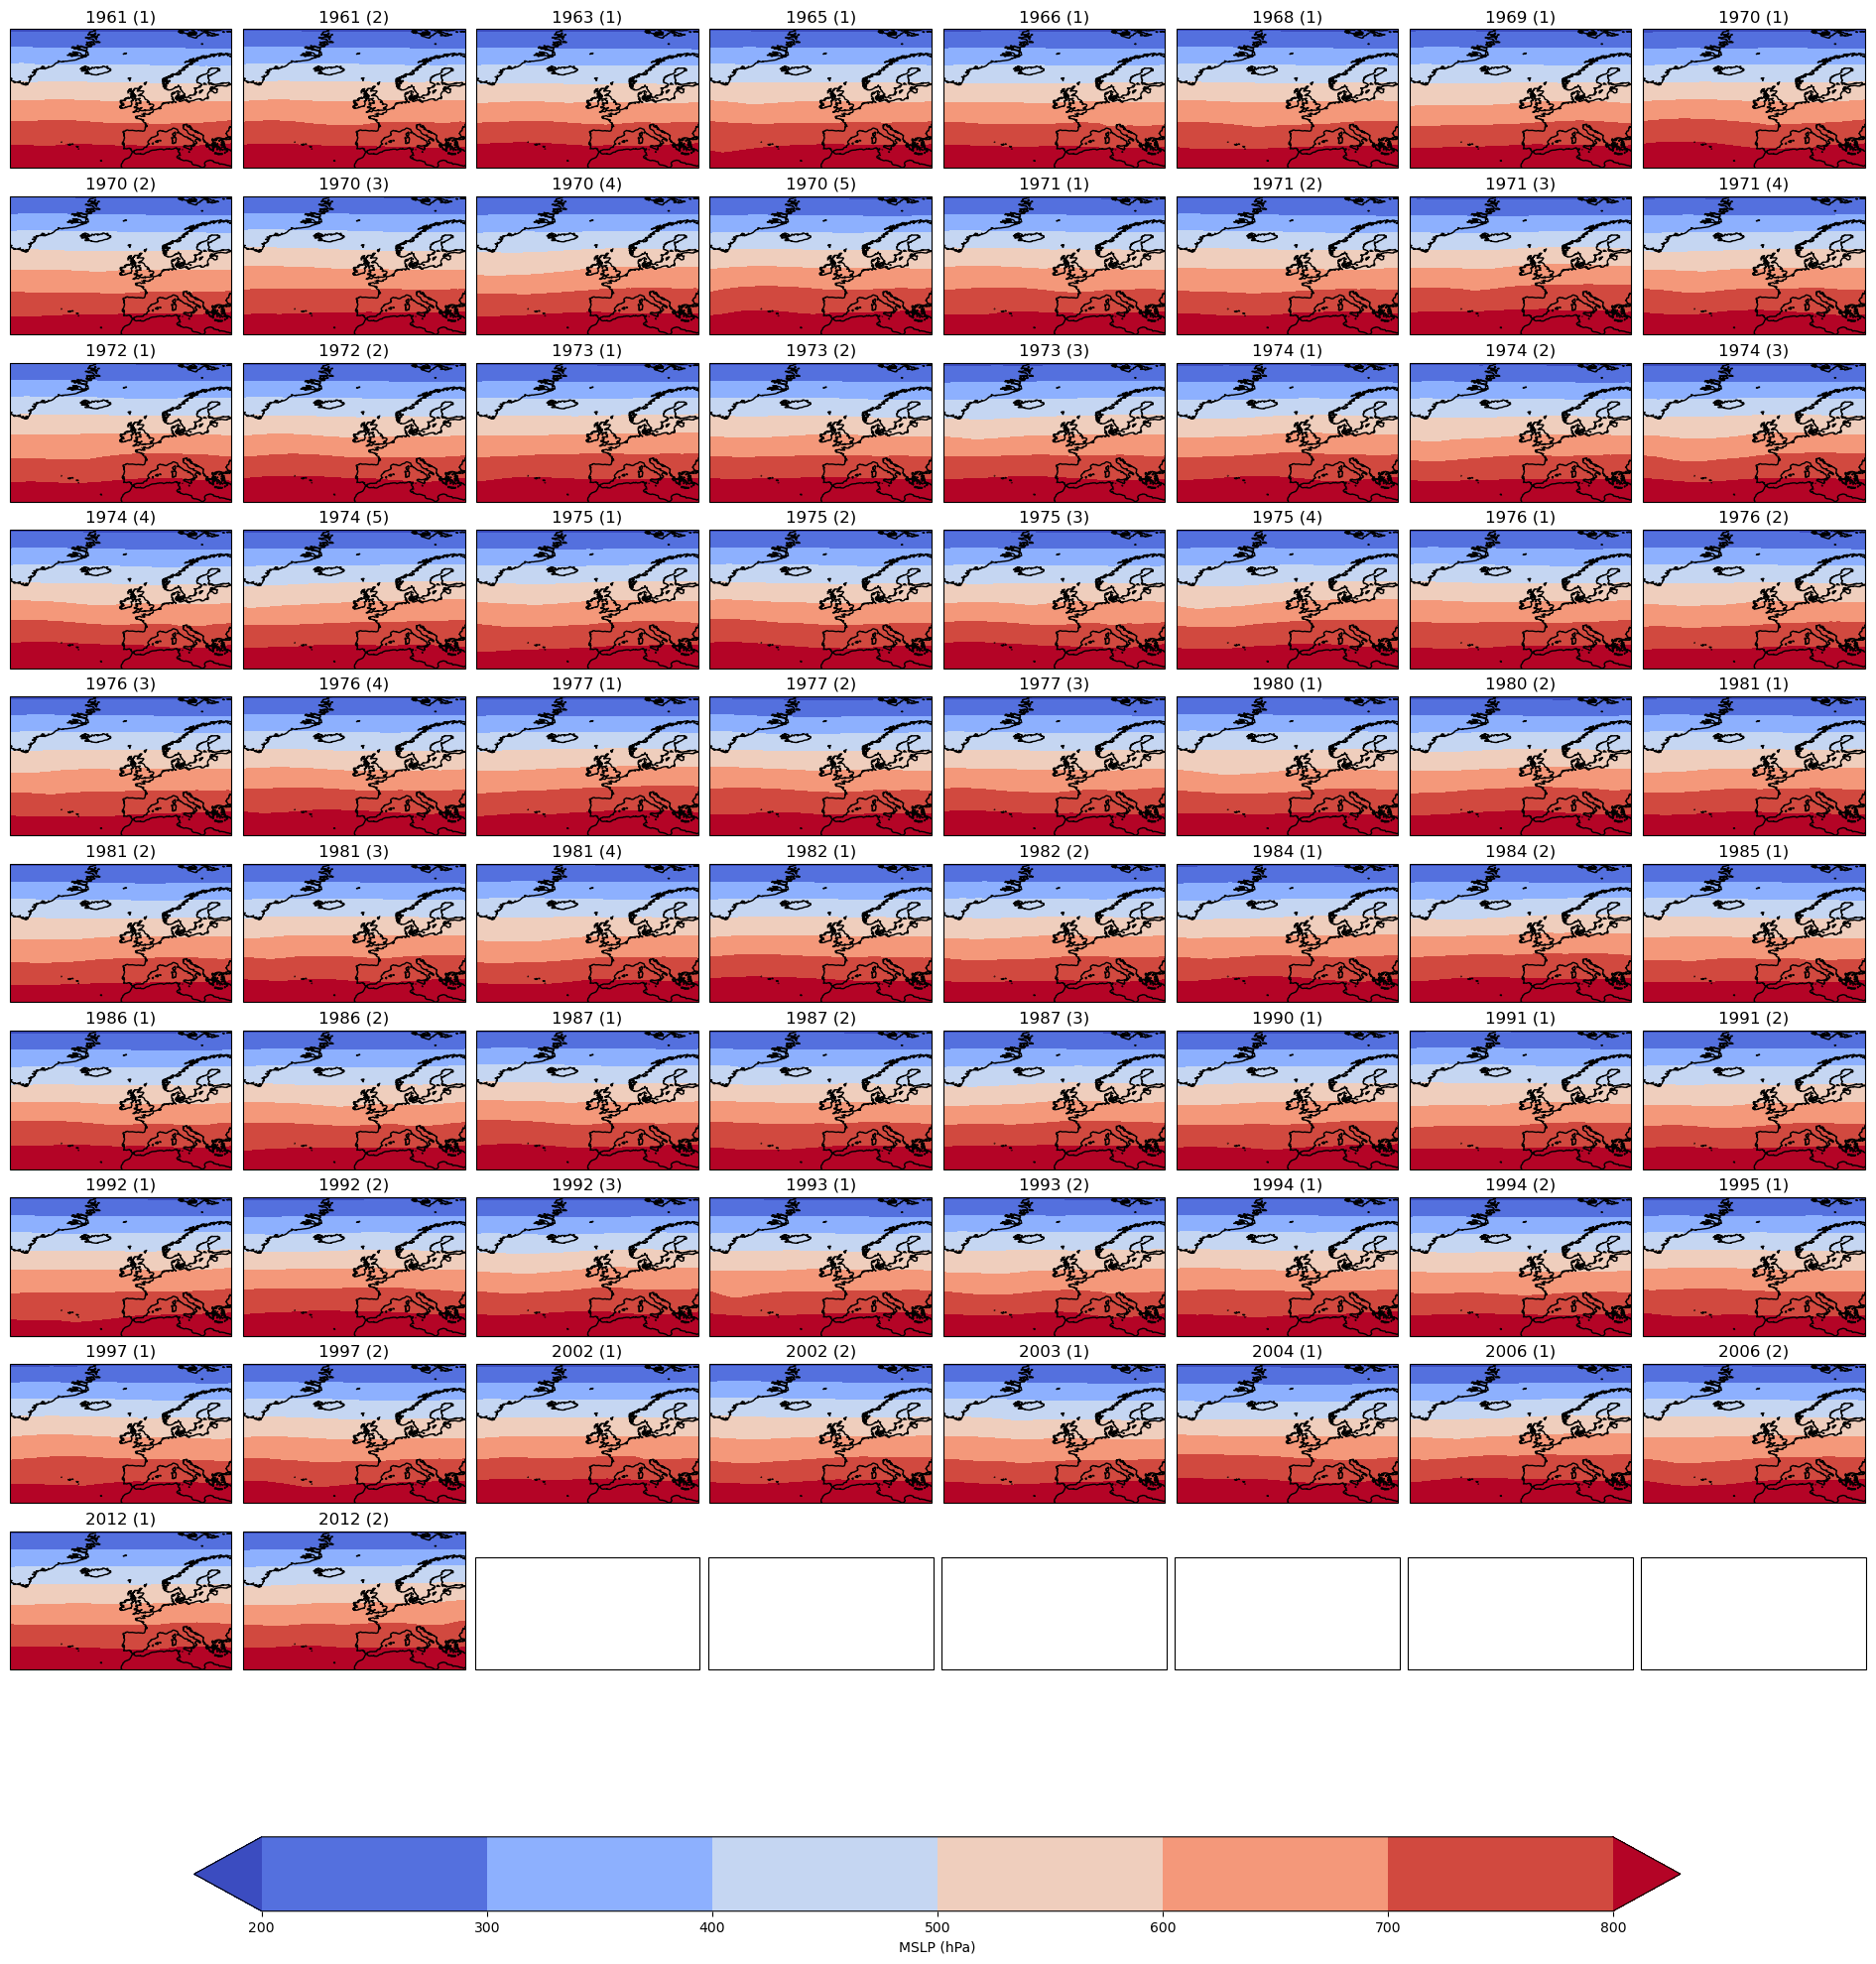

In [82]:
# Plot all of the data
# with 10 rows and 8 columns
fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(20, 20), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# Set up the years to loop over
years_list = np.arange(1960, 2018, 1)

# flatten the axeds
axs_flat = axs.flatten()

axs_index = 0

# Loop over the years list
for i, year in tqdm(enumerate(years_list), desc="Looping over years"):
    # check whether the year is in the red dots df
    if year not in red_dots_df["effective_dec_year"].unique():
        print(f"Year {year} not in red dots df")
        continue

    # # print that the year is in the red dots df
    # print(f"Year {year} in red dots df")

    # Find the indexes of the rows which have data for this year
    year_indexes = np.where(red_dots_df["effective_dec_year"] == year)[0]

    # # print the year indexes
    # print(year_indexes)

    # Loop over the indexes
    for j, index in enumerate(year_indexes):
        # extract this index from the red dots arr
        red_dots_arr_this = red_dots_arr[index, :, :]

        # # print the shape of the red dots arr this
        # print(red_dots_arr_this.shape)

        # Plot the data at this index
        im = axs_flat[axs_index].contourf(lons, lats, red_dots_arr_this / 100, cmap="coolwarm", extend="both")

        # add coastlines
        axs_flat[axs_index].coastlines()

        # add the title
        axs_flat[axs_index].set_title(f"{year} ({j+1})")

        # increment the axs index
        axs_index += 1

# add the colorbar
cbar = fig.colorbar(im, ax=axs_flat, orientation="horizontal", label="MSLP (hPa)", pad=0.1, shrink=0.8)

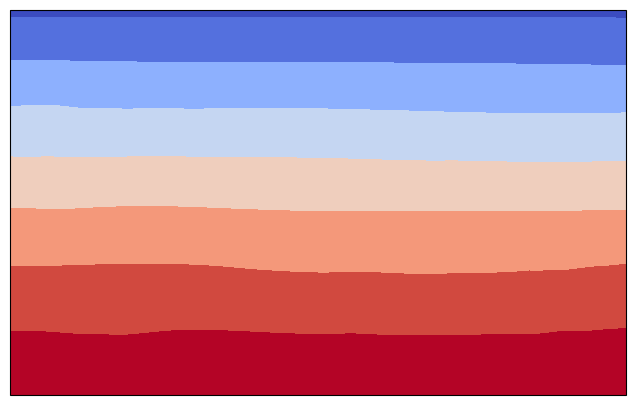

In [91]:
# plot the first one
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# plot the data
im = ax.contourf(lons, lats, red_dots_arr[0] / 100, cmap="coolwarm", extend="both")

In [92]:
red_dots_arr[0].shape

(90, 96)

In [ ]:
lats

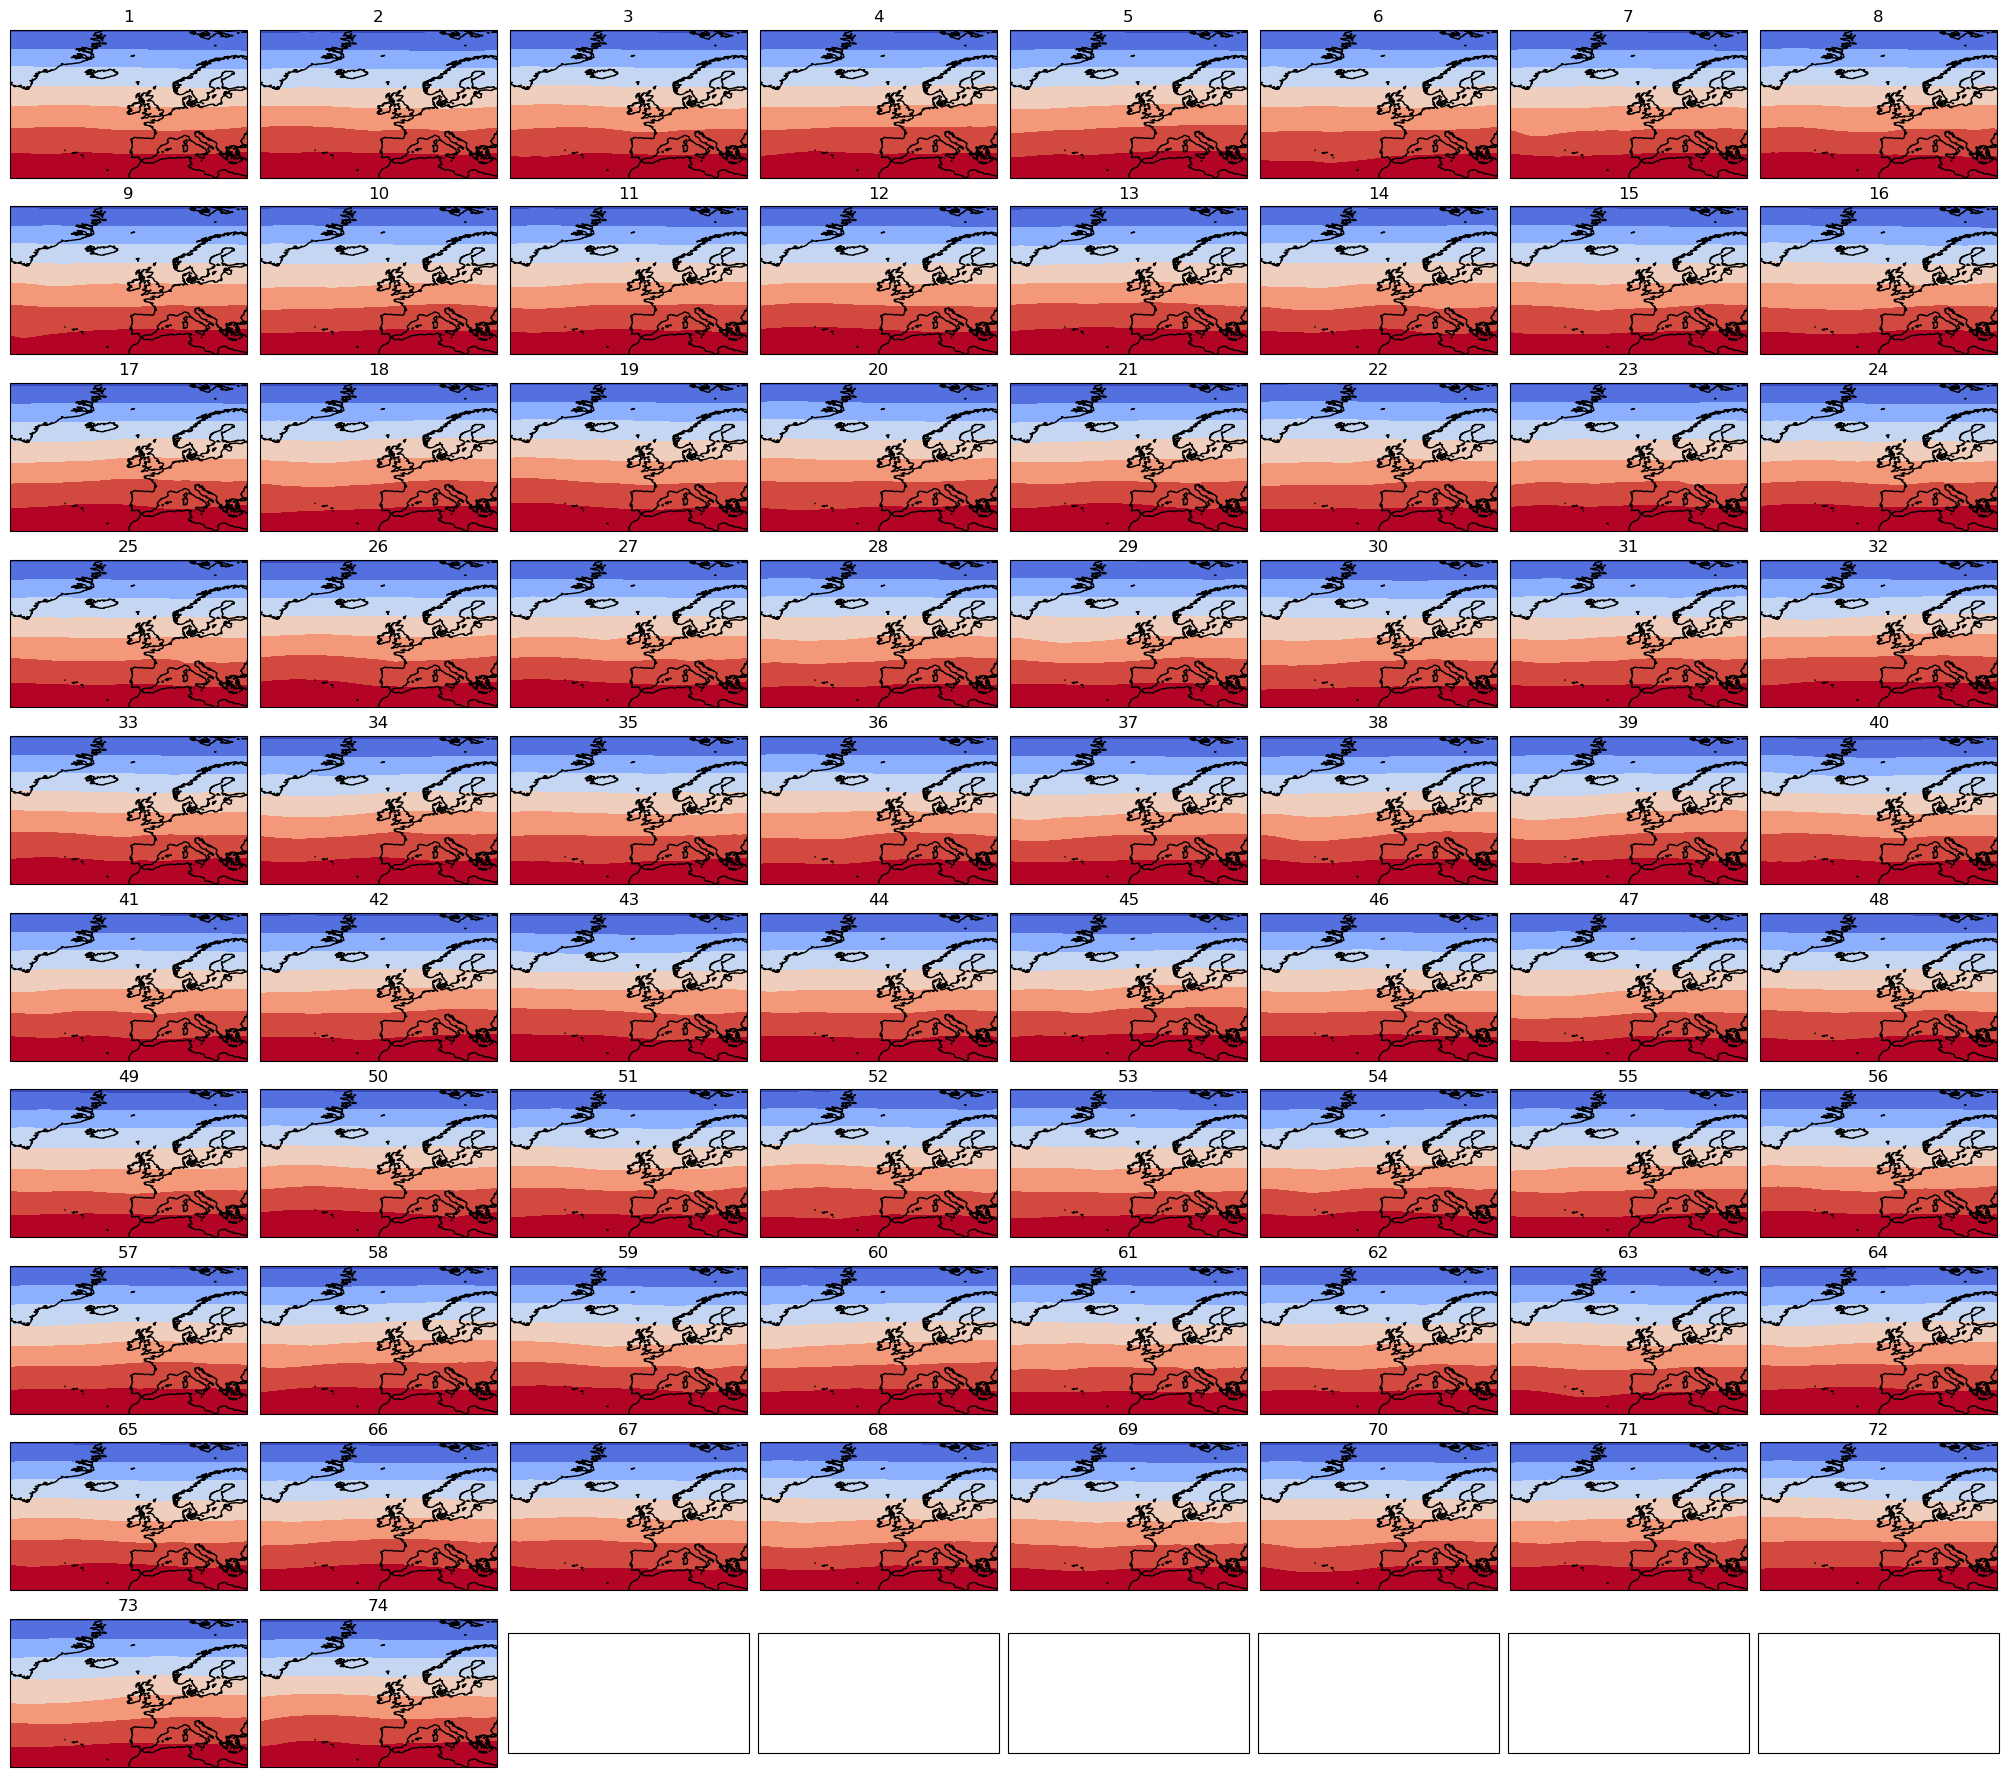

In [85]:
# set up the figure
# Plot all of the data
# with 10 rows and 8 columns
fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(20, 20), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# Set up the years to loop over
years_list = np.arange(1960, 2018, 1)

# flatten the axeds
axs_flat = axs.flatten()

# loop over and plot all of red_dots_arr
for i in range(red_dots_arr.shape[0]):
    # Plot the data at this index
    im = axs_flat[i].contourf(lons, lats, red_dots_arr[i] / 100, cmap="coolwarm", extend="both")

    # add coastlines
    axs_flat[i].coastlines()

    # add the title
    axs_flat[i].set_title(f"{i+1}")



In [14]:
# Set up the shape of the full model array
model_arr_full = np.zeros((len(years_list), test_arr.shape[1], test_arr.shape[2], test_arr.shape[3], test_arr.shape[4]))

# Loop over the years list
for i, year in tqdm(enumerate(years_list), desc="Looping over years"):
    # Form the file path
    model_arr_path = os.path.join(
        save_dir,
        f"{model}_{var_name}_{region}_{year}_{season}_{temp_res}.npy",
    )

    # if the file does not exist then raise an error
    if not os.path.exists(model_arr_path):
        raise ValueError(f"File does not exist: {model_arr_path}")
    
    # Load the data for this year
    # arr_this_year = np.load(model_arr_path)
    arr_this_year = np.load(model_arr_path)

    # if the shape of the 2th dimension is not equal to the test array then raise an error
    if arr_this_year.shape[2] != arr_shape:
        print(f"Shape of array for year {year} is {arr_this_year.shape}")
        arr_this_year = arr_this_year[:, :, 0:arr_shape, :, :]

    # add the data to the model array
    model_arr_full[i] = arr_this_year

Looping over years: 11it [00:15,  1.60s/it]

Shape of array for year 1972 is (1, 10, 3760, 90, 96)


Looping over years: 29it [00:51,  2.94s/it]